# Library

In [41]:
from beb_chargers.scripts.script_helpers import build_trips_df, build_charger_location_inputs
from beb_chargers.opt.charger_location import ChargerLocationModel
from beb_chargers.gtfs_beb import GTFSData
from beb_chargers.vis import plot_trips_and_terminals, plot_deadhead
from pathlib import Path
import datetime
import pandas as pd
import logging
logging.basicConfig(level=logging.INFO)

import numpy as np
import matplotlib.pyplot as plt
import os

In [42]:
plt.rcParams["font.family"] = "Times New Roman"

# Parameters

In [43]:
# Define a reusable image save path
image_dir = r"C:\Users\chris\OneDrive - UW\Documents\GitHub\CET593project1\image"
result_dir = r"C:\Users\chris\OneDrive - UW\Documents\GitHub\CET593project1\results"

## site locations

In [44]:
alpha = 190 * 365 * 12 / 60

# coordinate location for overnight depot
depot_coords = (40.819197, -73.957060)

# power output
chg_pwrs = 450 / 60

# max number of chargers per site
n_max_list = [8, 4]

# costs
s_cost_list = [200000, 500000, 800000]
c_cost_list = [600000, 800000, 1000000]

In [45]:
# location candidates
site_fname = Path.cwd().parent / 'beb_chargers' / 'data' / 'selected_chargers_nyc.csv'

# load candidates
loc_df = pd.read_csv(site_fname)
loc_df['kw'] = chg_pwrs * 60

In [46]:
"""
loc_df['max_chargers'] = n_max
loc_df['fixed_cost'] = s_cost
loc_df['charger_cost'] = c_cost
"""

"\nloc_df['max_chargers'] = n_max\nloc_df['fixed_cost'] = s_cost\nloc_df['charger_cost'] = c_cost\n"

## bus routes

In [47]:
# date of operation
ocl_date = datetime.datetime(2025, 3, 14)

# energy consumption
kwh_per_mi = 3

# battery_capacity
# battery_cap_arr = np.arange(100, 551, 25)
battery_cap_list = [850, 650, 550, 450]

In [48]:
# Directory to GTFS files, as a platform-agnostic path
gtfs_dir = Path.cwd().parent / 'beb_chargers' / 'data' / 'gtfs' / 'GTFS'

# Load GTFS data into our custom object
gtfs = GTFSData.from_dir(gtfs_dir)

In [49]:
# All routes included in analysis
busy_routes = [
    'M15-SBS', 'Q58', 'B6', 'Bx12-SBS', 'B82-SBS', 'B46-SBS', 'B44-SBS', 'Q27', 'B41', 
    'Q44-SBS', 'B35', 'M14A-SBS', 'M14D-SBS', 'M101', 'Bx1', 'Bx2', 'SIM3', 'M60-SBS'
]

manhattan_busy_routes = [
    'M3', 'M34-SBS', 'M96', 'M102', 'M11', 'M79-SBS', 'M23-SBS'
]

beb_routes = busy_routes 
    # + manhattan_busy_routes

In [50]:

# Call helper function to build up DF
beb_trips = build_trips_df(
    gtfs=gtfs,
    date=ocl_date,
    routes=beb_routes,
    depot_coords=depot_coords,
    add_depot_dh=True,
    add_kwh_per_mi=False,
    add_durations=False,
    routes_60=[]
)

# Add a column giving energy consumption for each trip
beb_trips['kwh_per_mi'] = kwh_per_mi

In [51]:
# Record how many trips and blocks are active on our specified routes on this day
logging.info(
    '{}: There are {} total trips to be served by {} BEB blocks.'.format(
        ocl_date.strftime('%m/%d/%y'), len(beb_trips), beb_trips['block_id'].nunique()
    )
)

INFO:root:03/14/25: There are 5954 total trips to be served by 1097 BEB blocks.


In [52]:
# Create a map of the problem instance
inst_map = plot_trips_and_terminals(
    beb_trips, loc_df, gtfs.shapes_df, 'light'
)

# These config params make map downloads higher resolution
config = {
    'toImageButtonOptions': {
        'format': 'png',
        'scale': 3
    }
}
inst_map.show(config=config)
# image_fname = 'bus_route_map.png'
# save_path = os.path.join(image_dir, image_fname)
# inst_map.write_image(save_path)

In [53]:
def loc_df_func(n_max, s_cost, c_cost, loc_df=loc_df):
    loc_df['max_chargers'] = n_max
    loc_df['fixed_cost'] = s_cost
    loc_df['charger_cost'] = c_cost
    return loc_df

def build_charger_loc_inputs_func(battery_cap, loc_df, gtfs=gtfs, beb_trips=beb_trips, depot_coords=depot_coords):
    return build_charger_location_inputs(
            gtfs=gtfs,
            trips_df=beb_trips,
            chargers_df=loc_df,
            depot_coords=depot_coords,
            battery_cap=battery_cap
        )

def create_instance(opt_kwargs):
    return ChargerLocationModel(**opt_kwargs)

In [54]:
def opt_model(n_max, s_cost, c_cost, battery_cap, gtfs=gtfs, beb_trips=beb_trips, loc_df=loc_df, depot_coords=depot_coords):
    loc_df = loc_df_func(n_max, s_cost, c_cost, loc_df=loc_df)
    opt_kwargs = build_charger_loc_inputs_func(battery_cap, loc_df, gtfs=gtfs, beb_trips=beb_trips, depot_coords=depot_coords)
    clm = create_instance(opt_kwargs)
    print('Instance created')
    clm.solve(alpha=alpha, opt_gap=0, bu_kwh=battery_cap)
    print('Solved')
    save_path_csv = os.path.join(result_dir, f"result_{n_max:01d}_{s_cost:06d}_{c_cost:07d}_{battery_cap:03d}_15.csv")
    save_path_sumcsv = os.path.join(result_dir, f"result_summary_{n_max:01d}_{s_cost:06d}_{c_cost:07d}_{battery_cap:03d}_15.csv")
    clm.to_csv(save_path_csv)
    clm.summary_to_csv(save_path_sumcsv)
    print('File saved')
    tmp_df = clm.to_df()
    if tmp_df.shape[0] > 0:
        save_path_plot_chargers = os.path.join(image_dir, f"plot_chargers_{n_max:01d}_{s_cost:06d}_{c_cost:07d}_{battery_cap:03d}_15.png")
        clm.plot_chargers(save_path_plot_chargers)
        """
        fig = plot_deadhead(
            result_df=clm.to_df(), loc_df=loc_df, coords_df=beb_trips
        )
        fig.show()
        """
    else:
        print('empty dataframe')

In [55]:
# opt_model(4, 800000, 1000000, 450, gtfs=gtfs, beb_trips=beb_trips, loc_df=loc_df, depot_coords=depot_coords)

INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpf0b6f6yt.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x956c41db
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp9o09fmco.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x72bb58bd
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp2jwcxf5r.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0xa8ea3909
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpbqnzo7kd.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x6368b5b5
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp_73w_h83.pyomo.lp
INFO:gurobipy:Reading time = 0.00 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0xfb63635b
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpscewed40.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0xc9827b56
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpbr3sjuse.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0xe798fffc
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp3jt02ib7.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0xd3fbcb33
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpp4vgozgn.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x8fa09db8
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpyr2e0mwq.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x598bb773
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp3czrpmoa.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x969bffec
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpgevv3eki.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x2743f845
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpnc46ogw7.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x213f4c34
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpvi83h1ga.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x3b332f88
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp_rg7ag5s.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0xbd0a1068
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmplle_gj2h.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x32b33faa
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp6m8beyyt.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x236f1eb8
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 0
INFO:charger_location:Number of trips in charging blocks: 0
INFO:charger_location:Number of infeasible blocks: 0


Instance created


INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp1w9ok1pj.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 7 rows, 14 columns, 14 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INFO:gurobipy:Optimize a model with 7 rows, 14 columns and 14 nonzeros
INFO:gurobipy:Model fingerprint: 0x28d5c7fc
INFO:gurobipy:Variable types: 0 continuous, 14 integer (7 binary)
INFO:gurobipy:Coefficient statistics:
INFO:gu

Solved
File saved
empty dataframe


INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.17 seconds
INFO:charger_location:Average number of backups: 3.96
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp1uw3_0mo.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


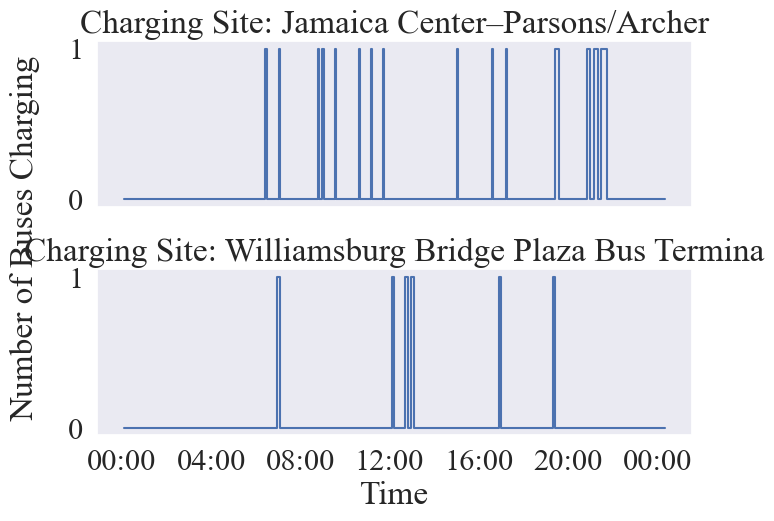

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.16 seconds
INFO:charger_location:Average number of backups: 4.02
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp486gxp54.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


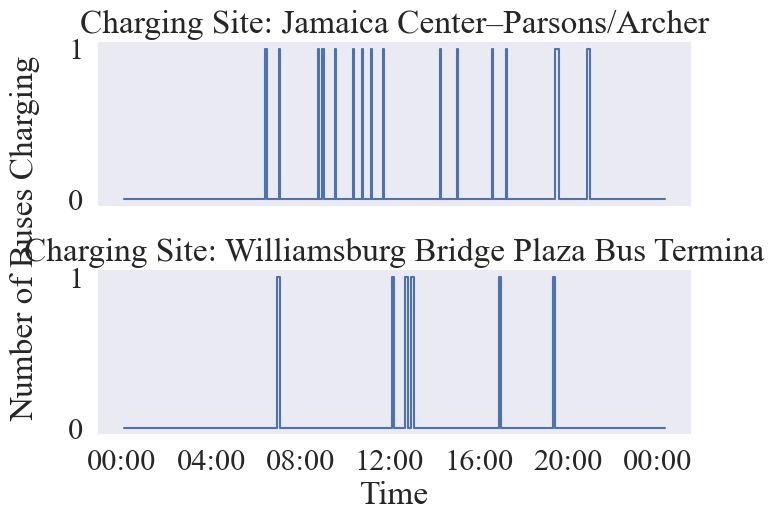

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.17 seconds
INFO:charger_location:Average number of backups: 3.98
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpn_askrw2.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


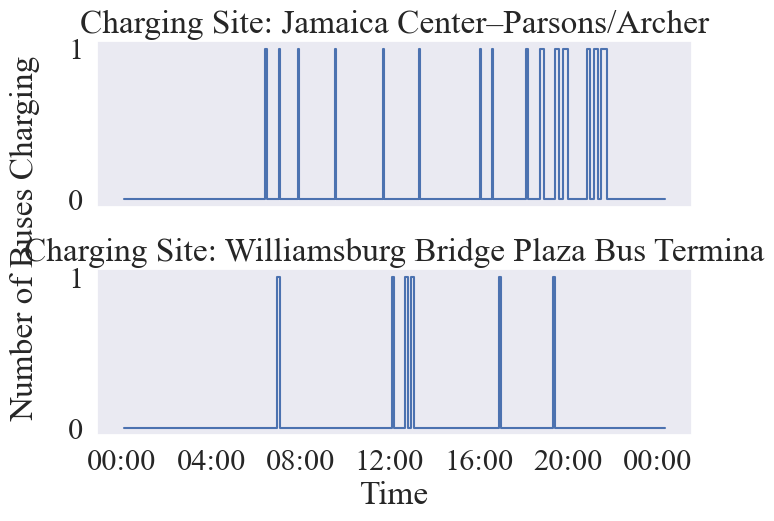

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.16 seconds
INFO:charger_location:Average number of backups: 4.02
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmptu3uxr8f.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


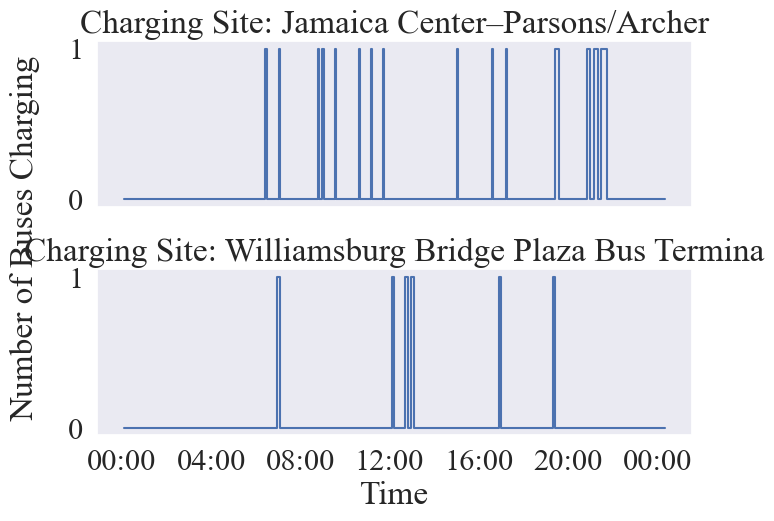

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.20 seconds
INFO:charger_location:Average number of backups: 4.00
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp2nulhzyc.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


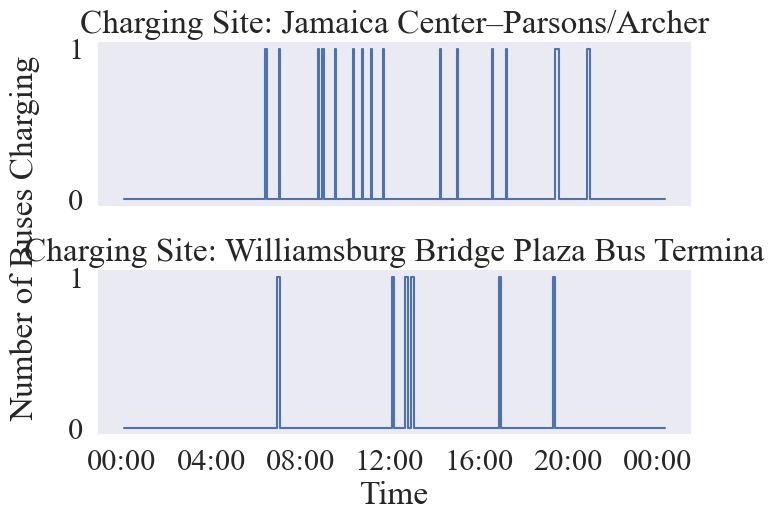

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.20 seconds
INFO:charger_location:Average number of backups: 3.94
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp9lo6aj2o.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


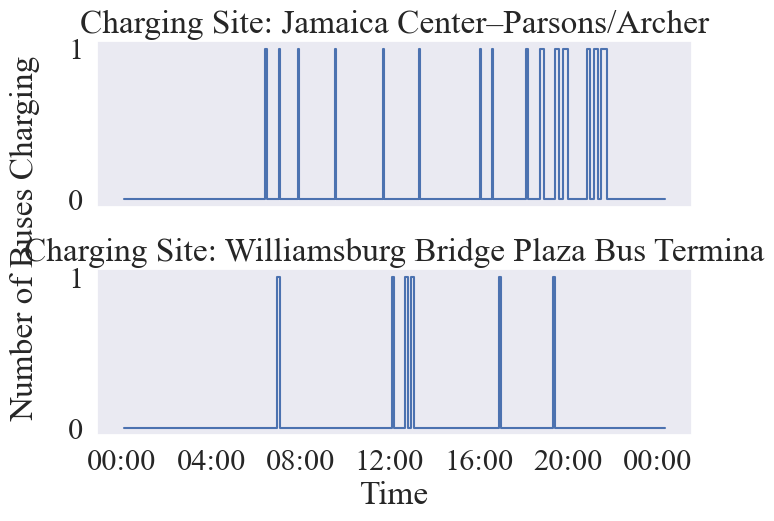

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.17 seconds
INFO:charger_location:Average number of backups: 4.00
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp0yz_mf7t.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


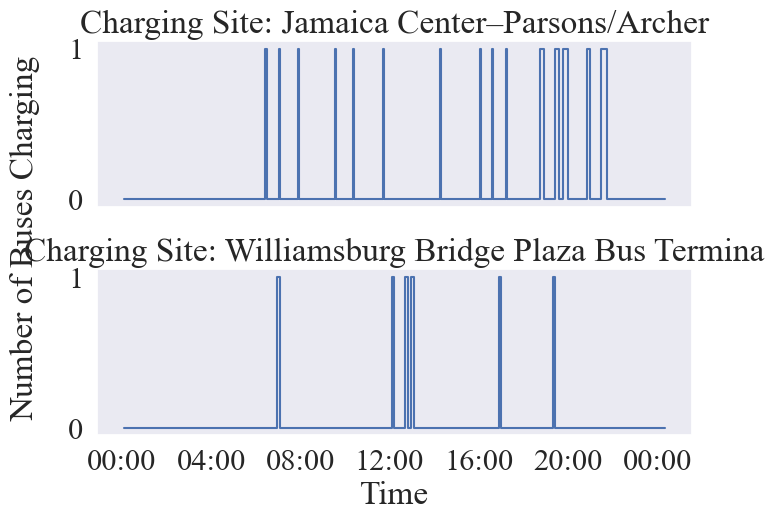

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.21 seconds
INFO:charger_location:Average number of backups: 3.98
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp2bq57b2p.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


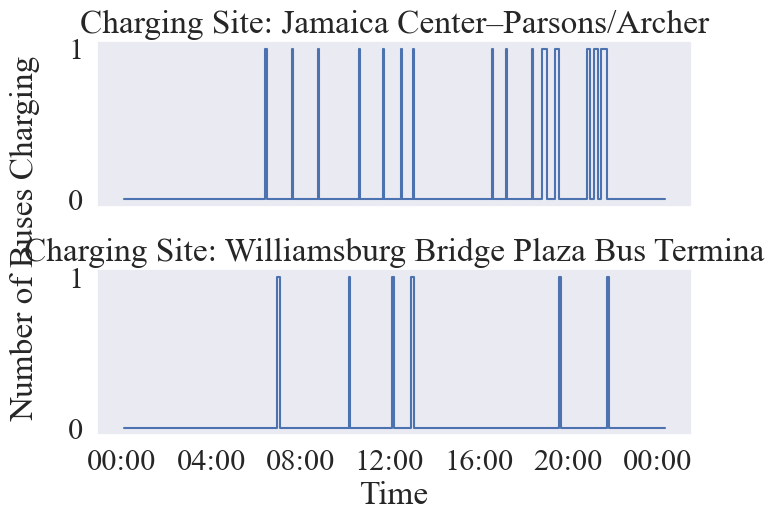

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.21 seconds
INFO:charger_location:Average number of backups: 4.00
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpr14ksm36.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


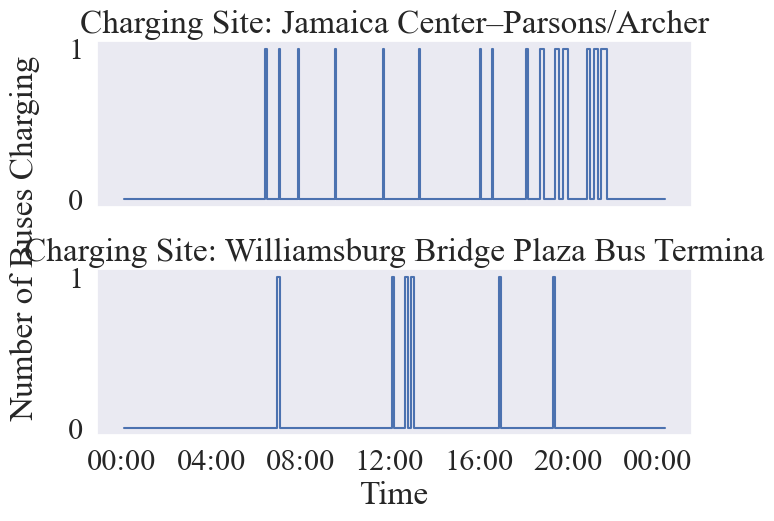

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.23 seconds
INFO:charger_location:Average number of backups: 3.96
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp_r1w_p8n.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


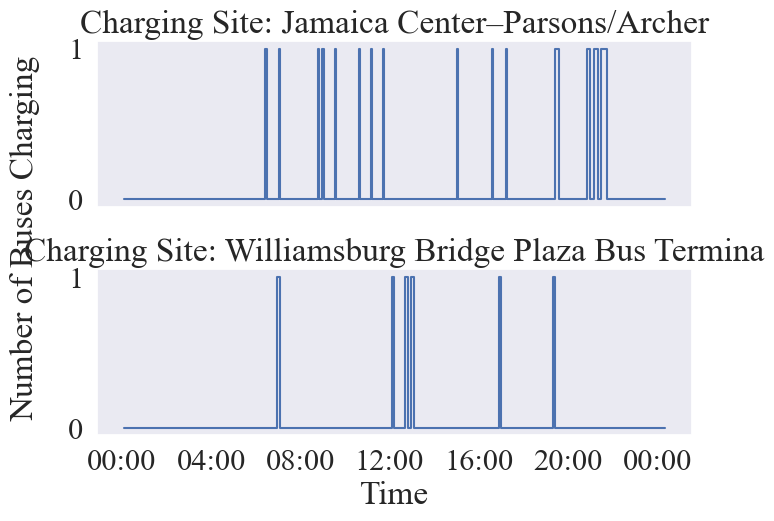

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.19 seconds
INFO:charger_location:Average number of backups: 3.98
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmphzxiqy8g.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


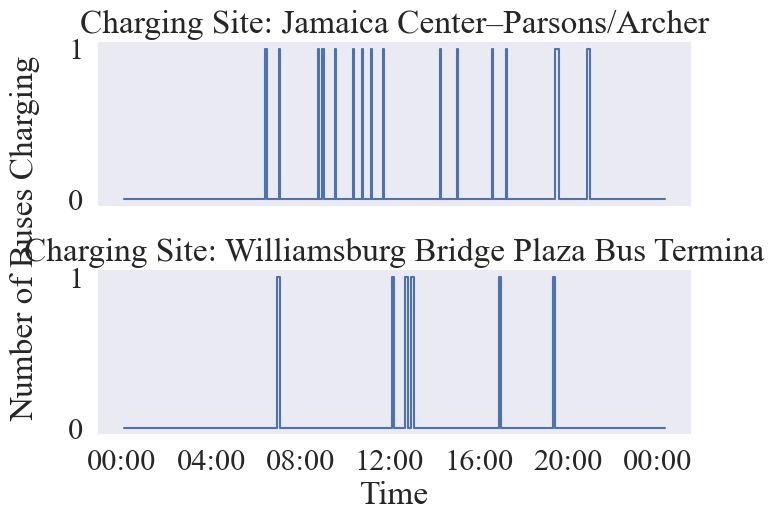

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.20 seconds
INFO:charger_location:Average number of backups: 4.00
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpg1vod3zn.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


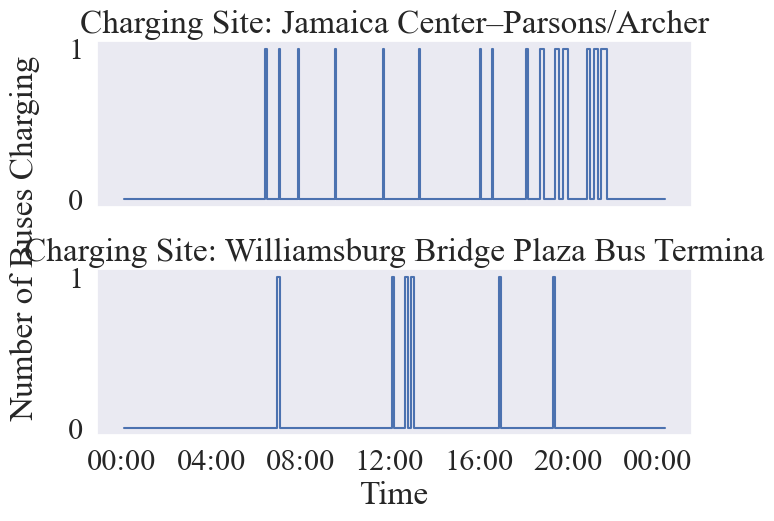

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.21 seconds
INFO:charger_location:Average number of backups: 3.96
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmptomo2en5.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


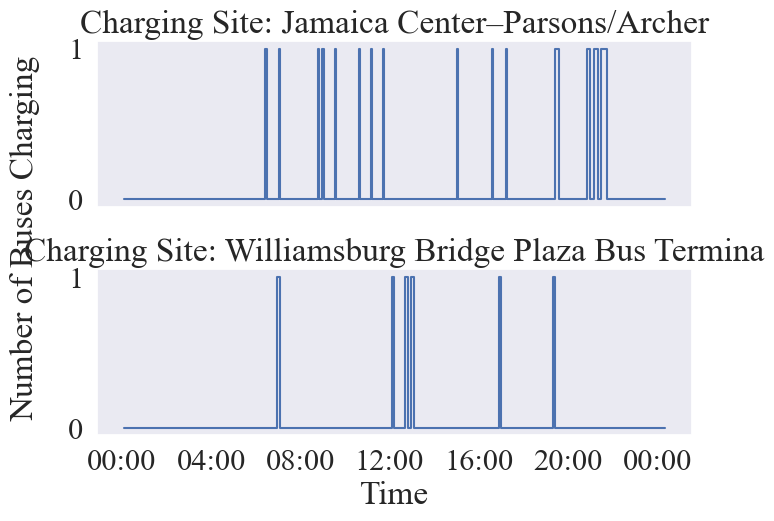

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.20 seconds
INFO:charger_location:Average number of backups: 3.96
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp1yrtedag.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


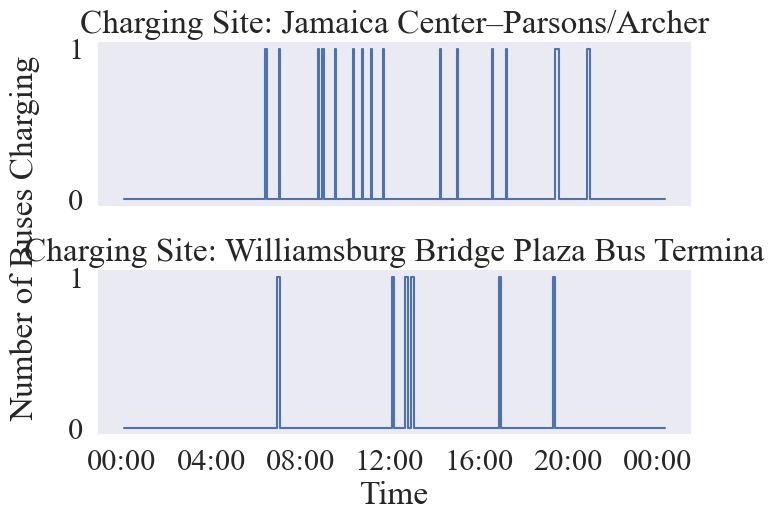

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.19 seconds
INFO:charger_location:Average number of backups: 4.02
INFO:charger_location:Minimum number of backups: 4

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpnc_rehw6.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


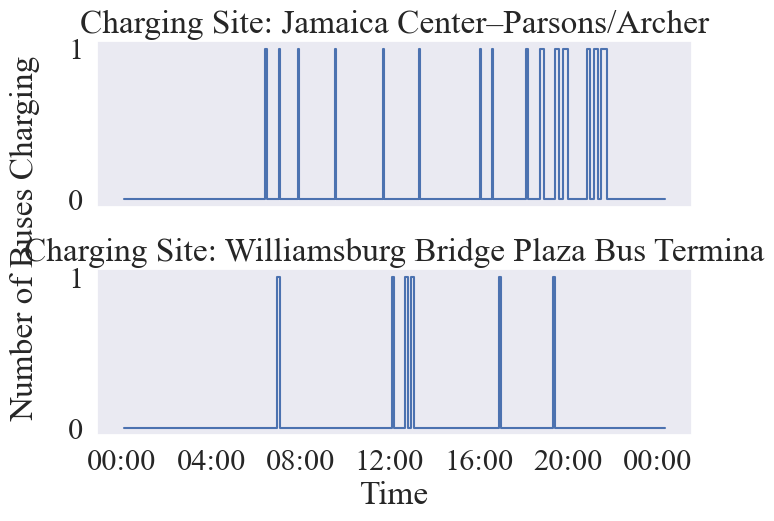

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.20 seconds
INFO:charger_location:Average number of backups: 3.96
INFO:charger_location:Minimum number of backups: 3

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpfnop9fov.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


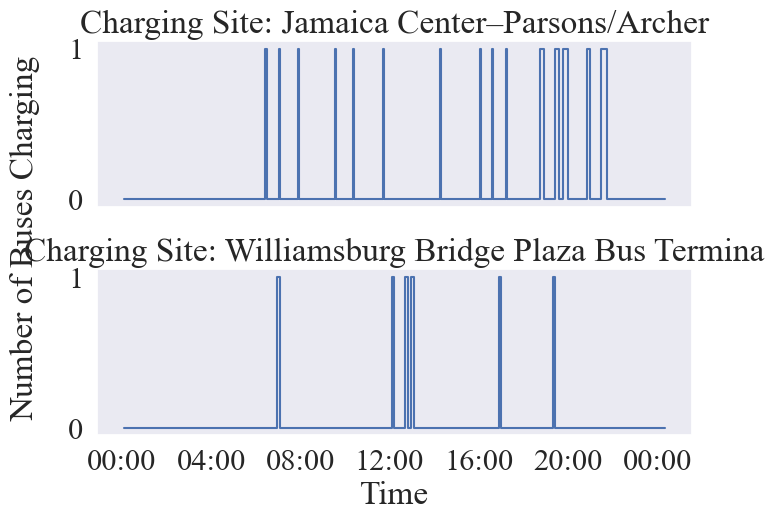

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.19 seconds
INFO:charger_location:Average number of backups: 4.00
INFO:charger_location:Minimum number of backups: 4

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpi7xas3up.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


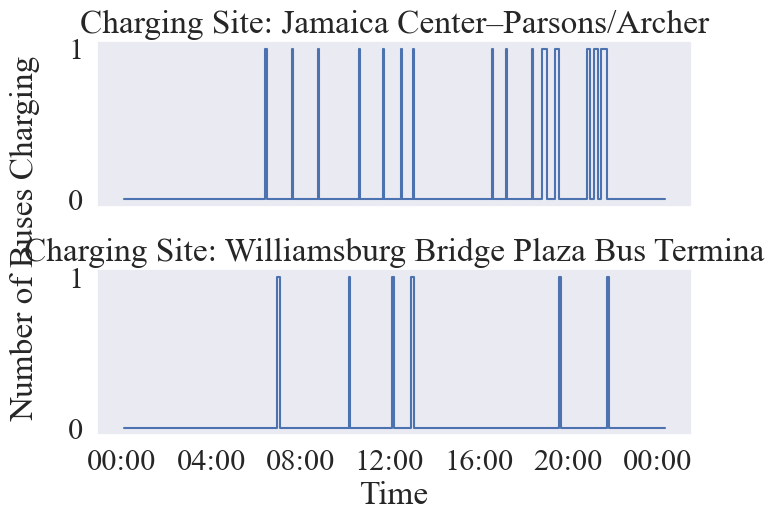

INFO:charger_location:Number of blocks that require charging: 26
INFO:charger_location:Number of trips in charging blocks: 360
INFO:charger_location:Number of infeasible blocks: 6
INFO:charger_location:Infeasible block IDs: ['36457033', '36457035', '36457128', '36457135', '36457136', '36457137']
INFO:charger_location:Number of trips in infeasible blocks: 94


Instance created


INFO:charger_location:Time for heuristic runs: 0.22 seconds
INFO:charger_location:Average number of backups: 4.00
INFO:charger_location:Minimum number of backups: 4

INFO:charger_location:Mean Conflict set size: 2.32
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpuuljnw2_.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 1342 rows, 730 columns, 3040 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:
INF

Solved
File saved


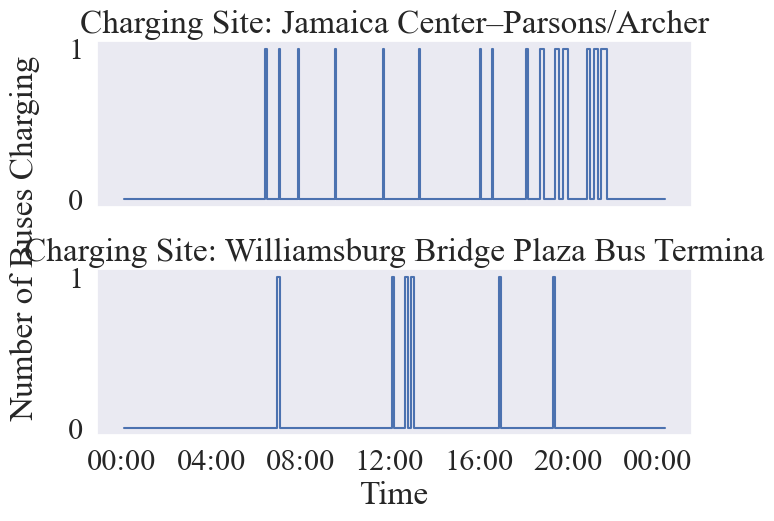

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 17.66 seconds
INFO:charger_location:Average number of backups: 18.02
INFO:charger_location:Minimum number of backups: 16

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp8ehbrpr7.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


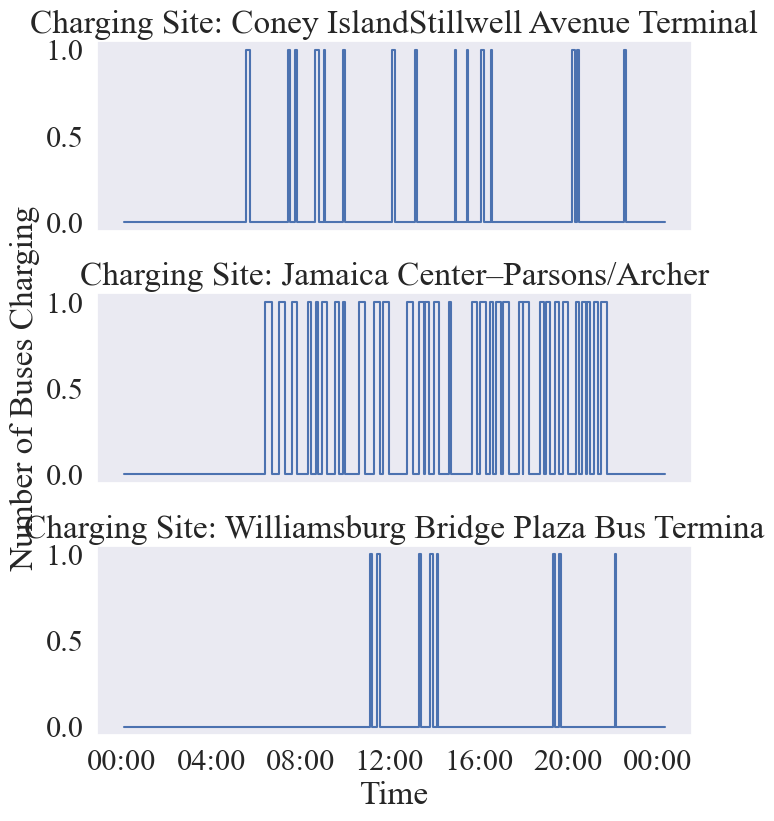

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 17.81 seconds
INFO:charger_location:Average number of backups: 17.94
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpi4q4ggln.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


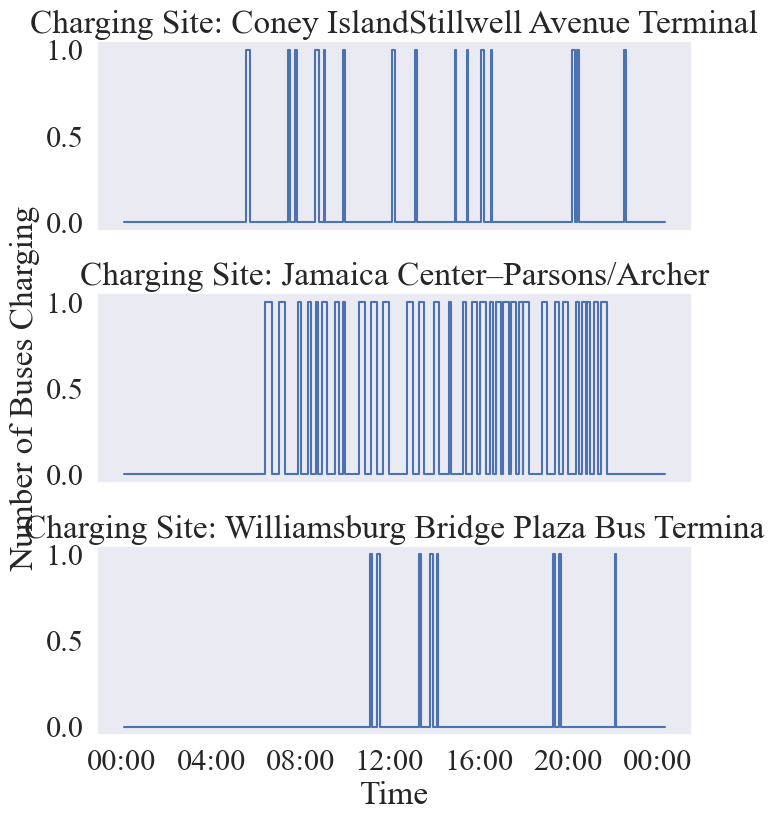

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 15.76 seconds
INFO:charger_location:Average number of backups: 17.92
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp9yoc9z_9.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


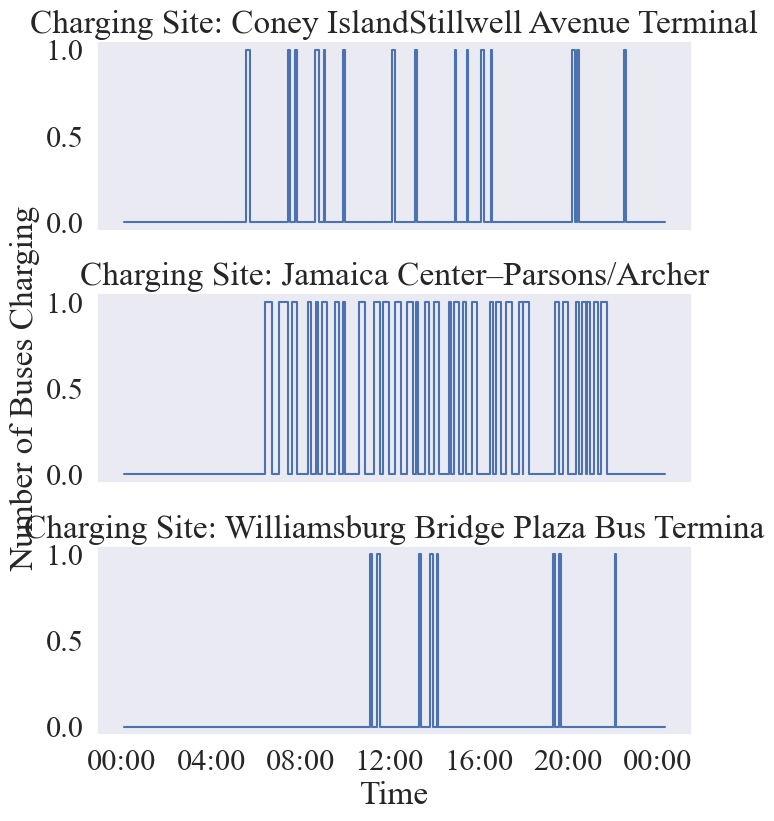

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 14.61 seconds
INFO:charger_location:Average number of backups: 18.06
INFO:charger_location:Minimum number of backups: 16

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp_8rvr6y1.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


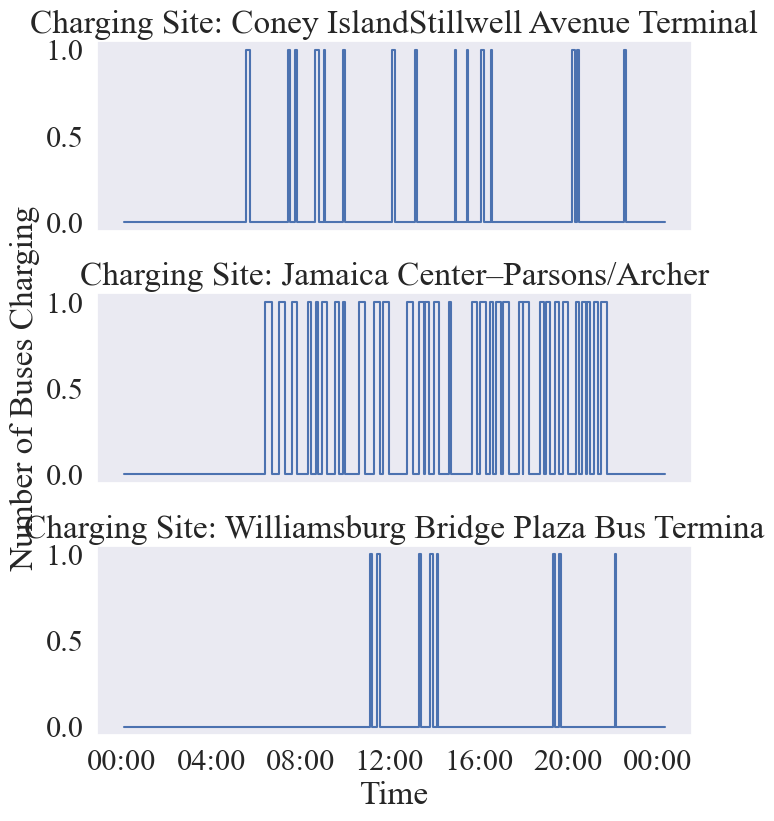

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 14.66 seconds
INFO:charger_location:Average number of backups: 17.96
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmporn2e6vz.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


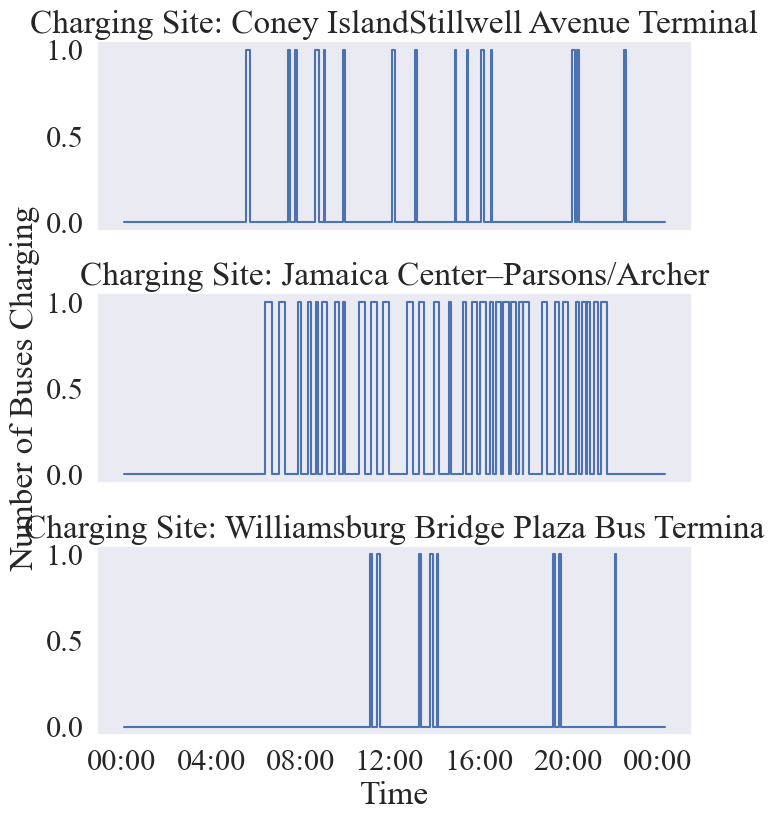

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 19.11 seconds
INFO:charger_location:Average number of backups: 18.02
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmptws17sr1.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


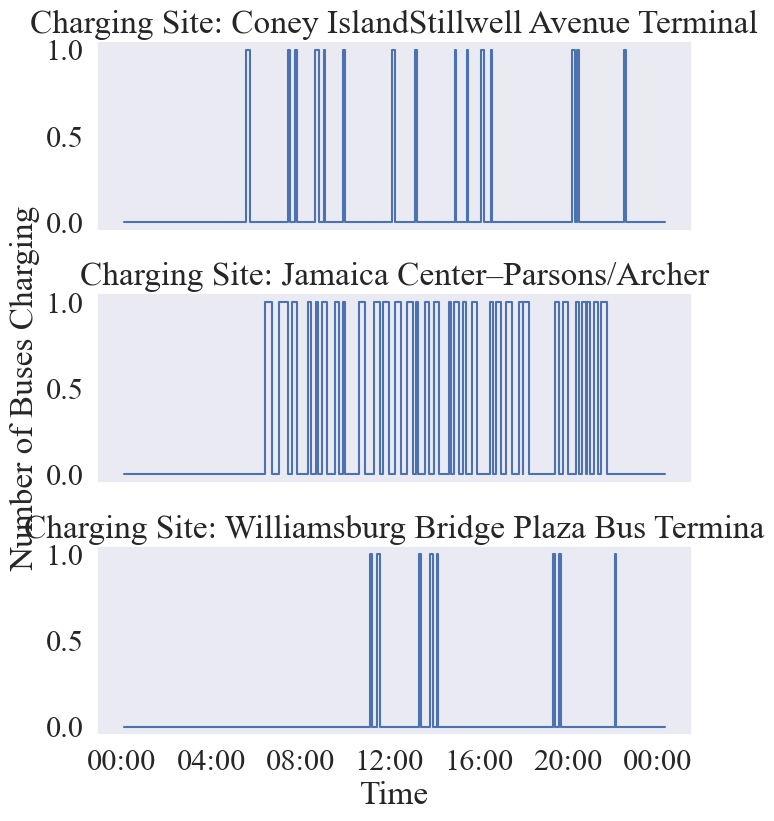

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 18.10 seconds
INFO:charger_location:Average number of backups: 17.92
INFO:charger_location:Minimum number of backups: 16

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpr60kh2l6.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


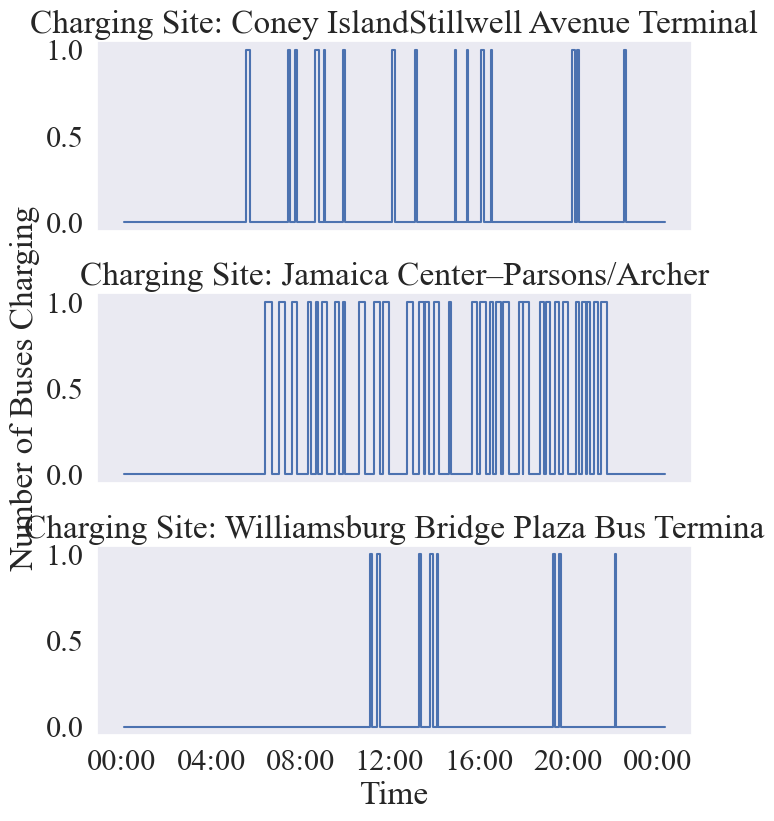

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 19.63 seconds
INFO:charger_location:Average number of backups: 18.10
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpvkvfkks7.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


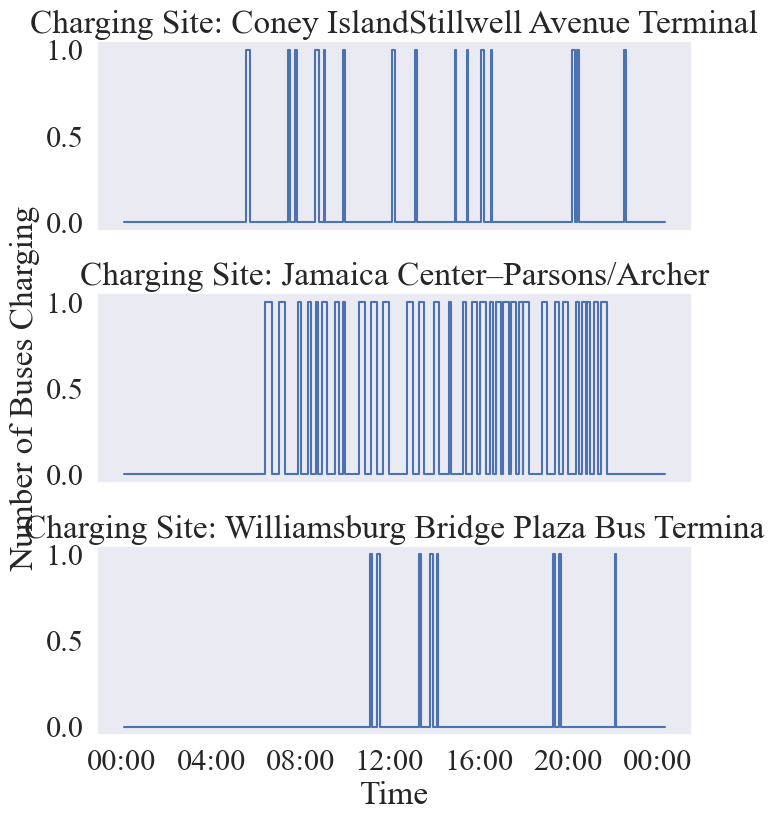

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 19.79 seconds
INFO:charger_location:Average number of backups: 18.10
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpmyqndiq4.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


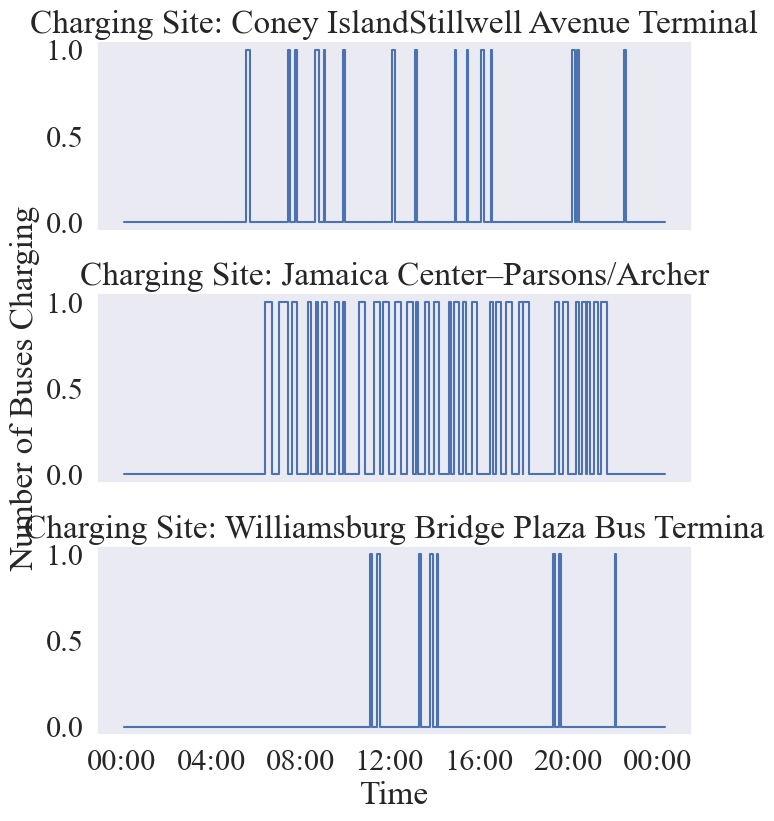

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 20.57 seconds
INFO:charger_location:Average number of backups: 18.06
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpl0baotdx.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


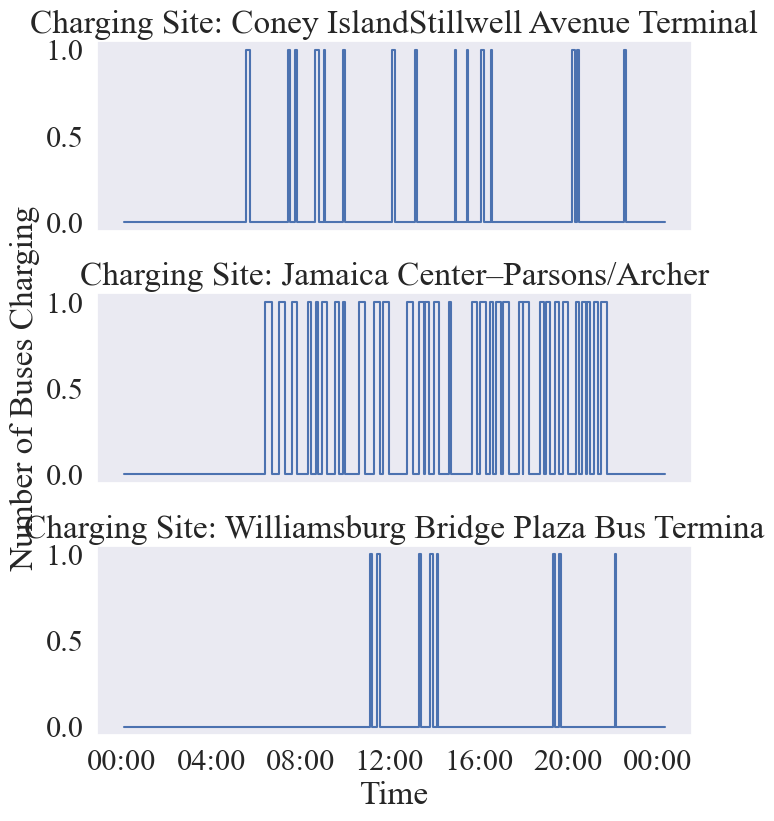

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 15.27 seconds
INFO:charger_location:Average number of backups: 17.96
INFO:charger_location:Minimum number of backups: 16

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpbhlvo051.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


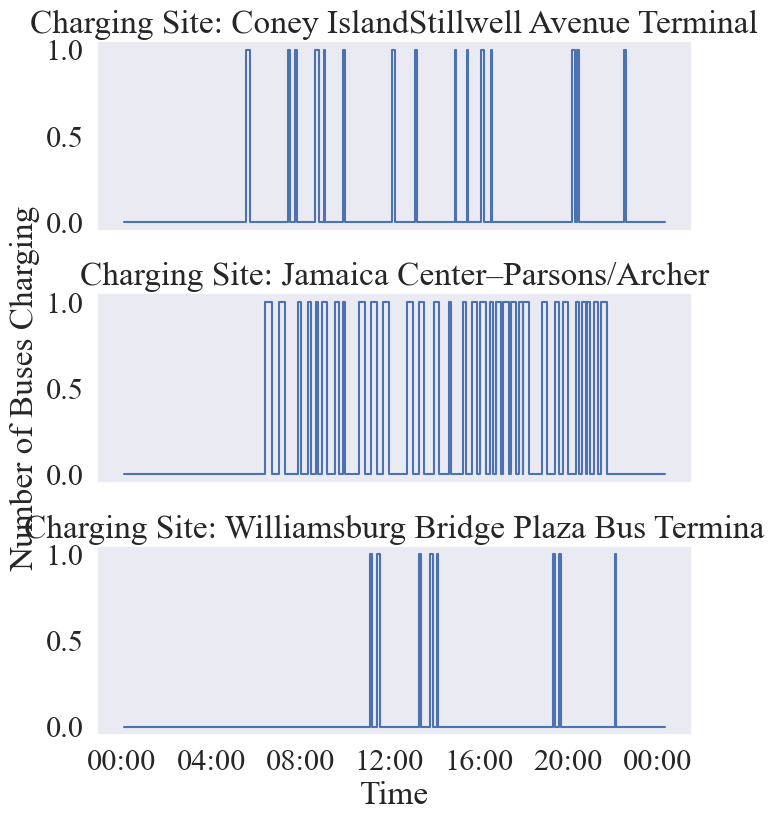

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 15.96 seconds
INFO:charger_location:Average number of backups: 17.92
INFO:charger_location:Minimum number of backups: 16

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpmjqvsndu.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


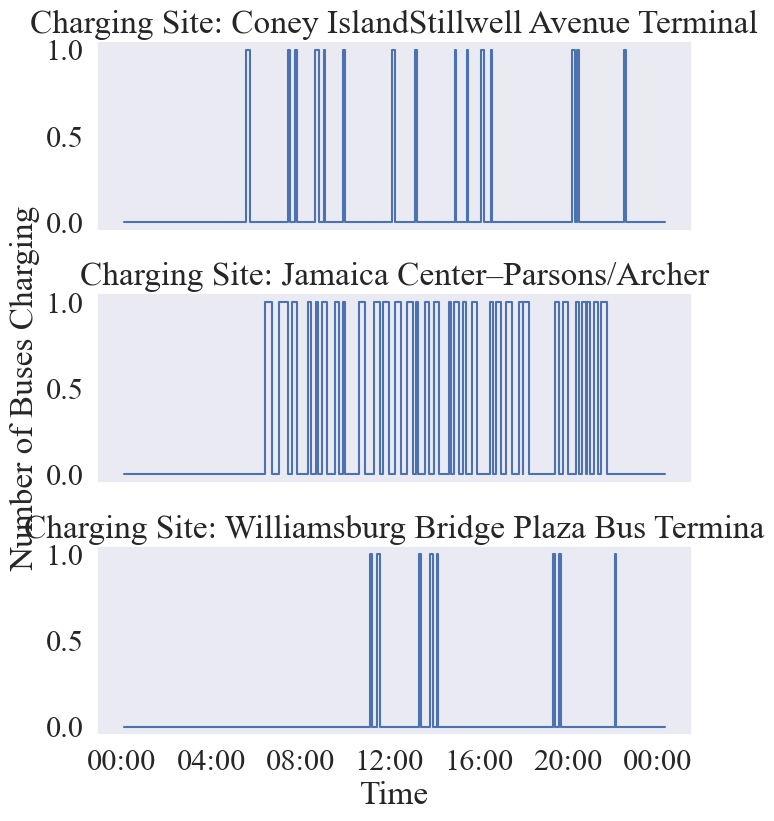

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 16.88 seconds
INFO:charger_location:Average number of backups: 18.00
INFO:charger_location:Minimum number of backups: 16

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmpdx528lq4.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


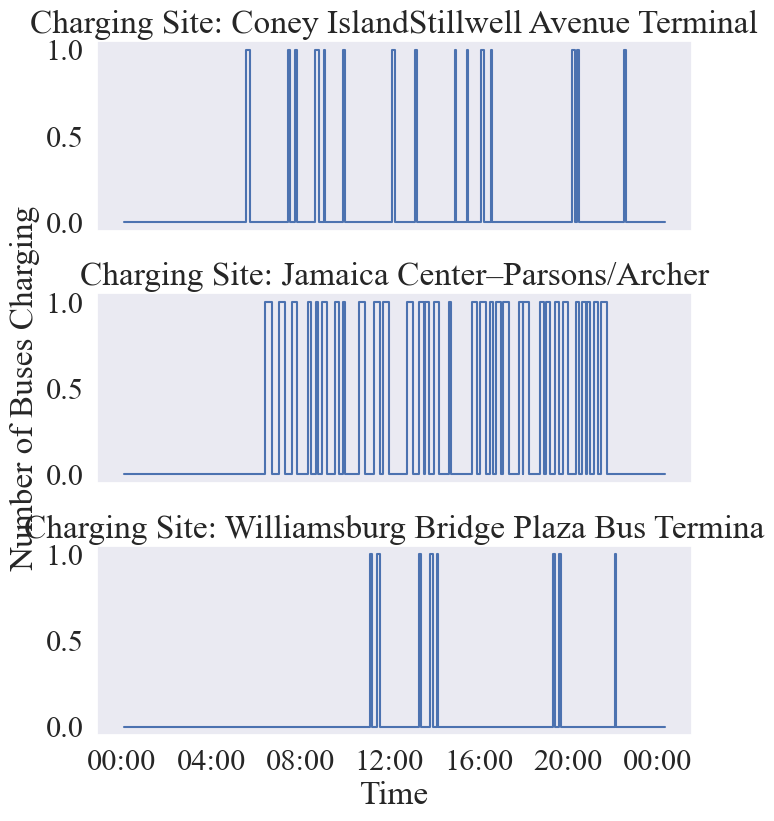

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 17.23 seconds
INFO:charger_location:Average number of backups: 17.94
INFO:charger_location:Minimum number of backups: 16

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp2xpgpotj.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


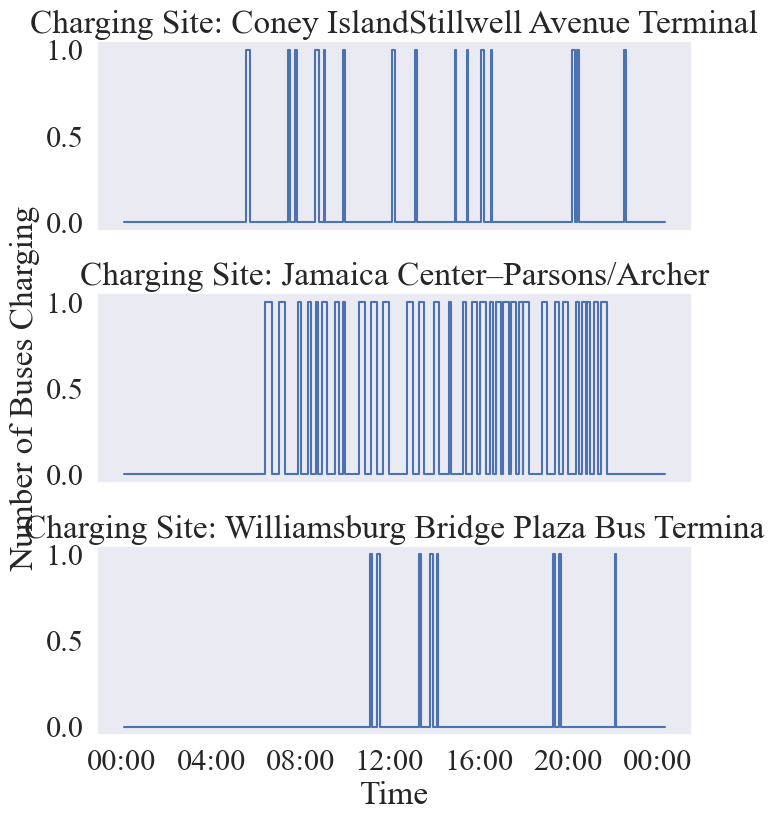

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 15.18 seconds
INFO:charger_location:Average number of backups: 17.98
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp_0tsj8x9.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


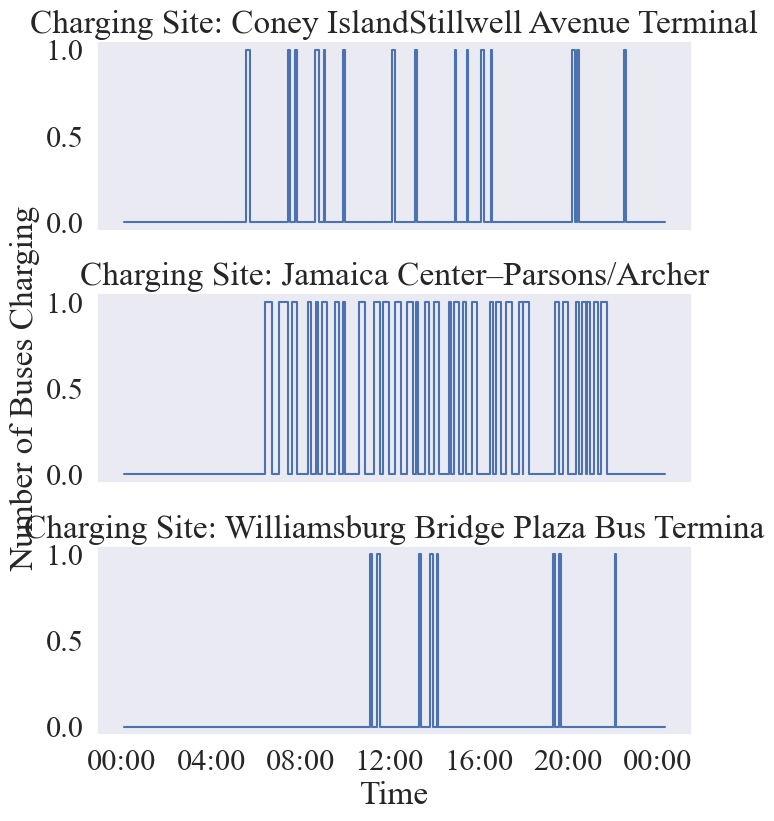

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 15.23 seconds
INFO:charger_location:Average number of backups: 17.98
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp1i3w83nc.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


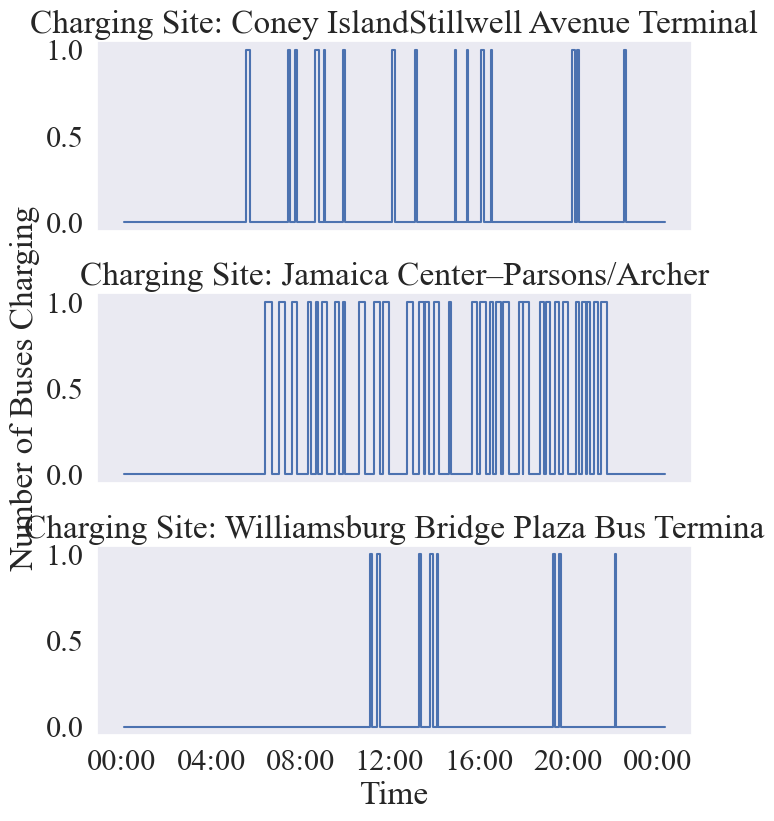

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 15.20 seconds
INFO:charger_location:Average number of backups: 18.04
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp9wk7ibad.pyomo.lp
INFO:gurobipy:Reading time = 0.02 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


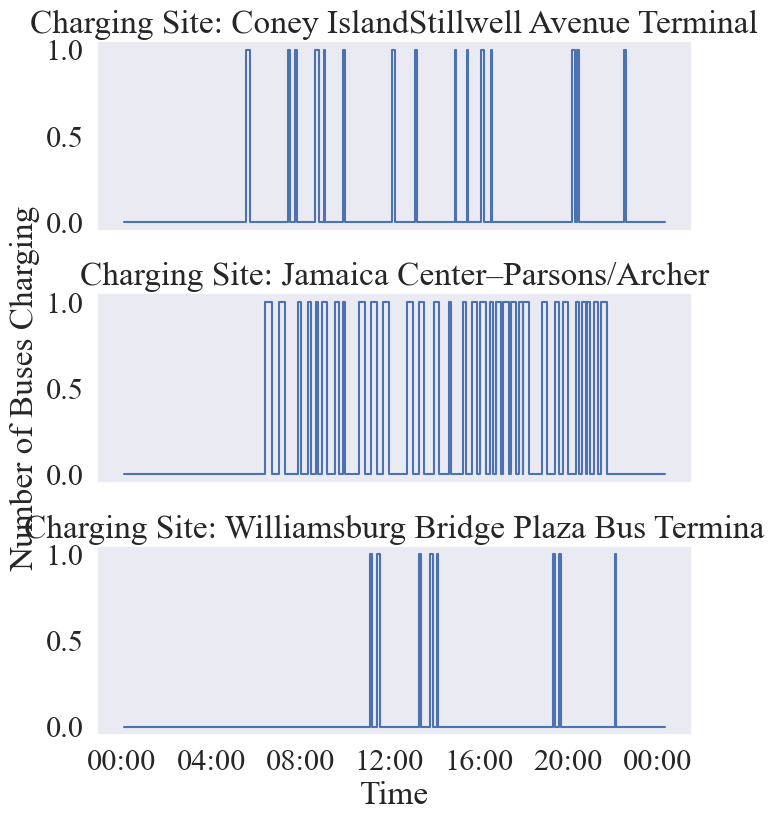

INFO:charger_location:Number of blocks that require charging: 71
INFO:charger_location:Number of trips in charging blocks: 939
INFO:charger_location:Number of infeasible blocks: 37
INFO:charger_location:Infeasible block IDs: ['36443450', '36443454', '36457004', '36457007', '36457015', '36457016', '36457017', '36457018', '36457020', '36457023', '36457025', '36457027', '36457031', '36457032', '36457033', '36457035', '36457037', '36457045', '36457047', '36457059', '36457125', '36457126', '36457128', '36457130', '36457135', '36457136', '36457137', '36457139', '36457162', '36457163', '36457164', '36457166', '36457192', '36457199', '36457203', '36457753', '36461362']
INFO:charger_location:Number of trips in infeasible blocks: 457


Instance created


INFO:charger_location:Time for heuristic runs: 15.39 seconds
INFO:charger_location:Average number of backups: 18.08
INFO:charger_location:Minimum number of backups: 17

INFO:charger_location:Mean Conflict set size: 3.08
INFO:gurobipy:Read LP format model from file C:\Users\chris\AppData\Local\Temp\tmp53x17140.pyomo.lp
INFO:gurobipy:Reading time = 0.01 seconds
INFO:gurobipy:x1: 2173 rows, 1186 columns, 4956 nonzeros
INFO:gurobipy:Set parameter MIPGap to value 0
INFO:gurobipy:Set parameter MIPFocus to value 3
INFO:gurobipy:Set parameter Method to value 1
INFO:gurobipy:Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))
INFO:gurobipy:
INFO:gurobipy:CPU model: 13th Gen Intel(R) Core(TM) i5-13450HX, instruction set [SSE2|AVX|AVX2]
INFO:gurobipy:Thread count: 10 physical cores, 16 logical processors, using up to 16 threads
INFO:gurobipy:
INFO:gurobipy:Non-default parameters:
INFO:gurobipy:MIPGap  0
INFO:gurobipy:Method  1
INFO:gurobipy:MIPFocus  3
INFO:gurobipy:

Solved
File saved


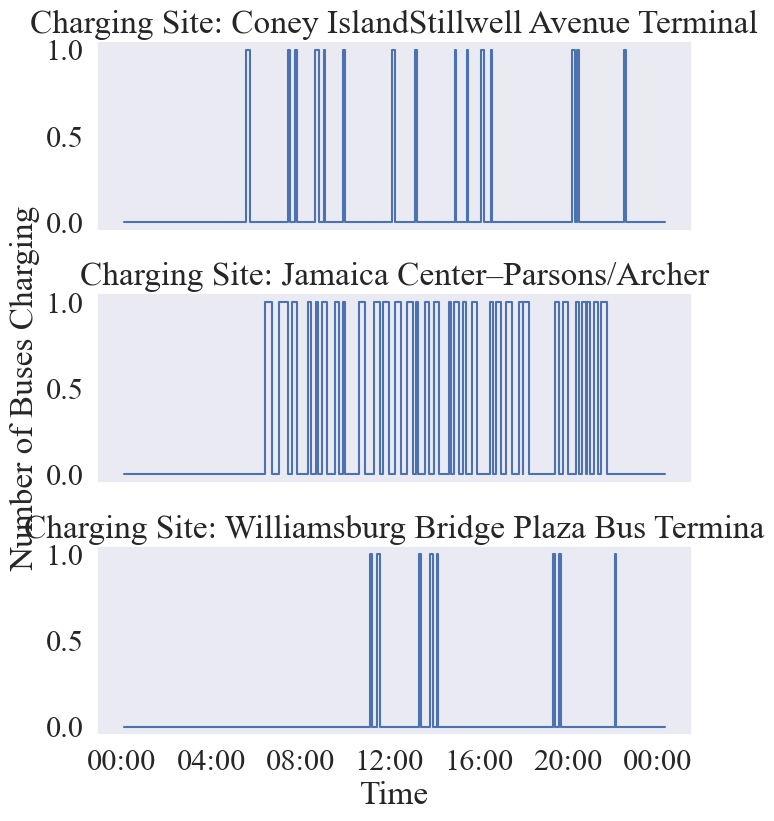

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


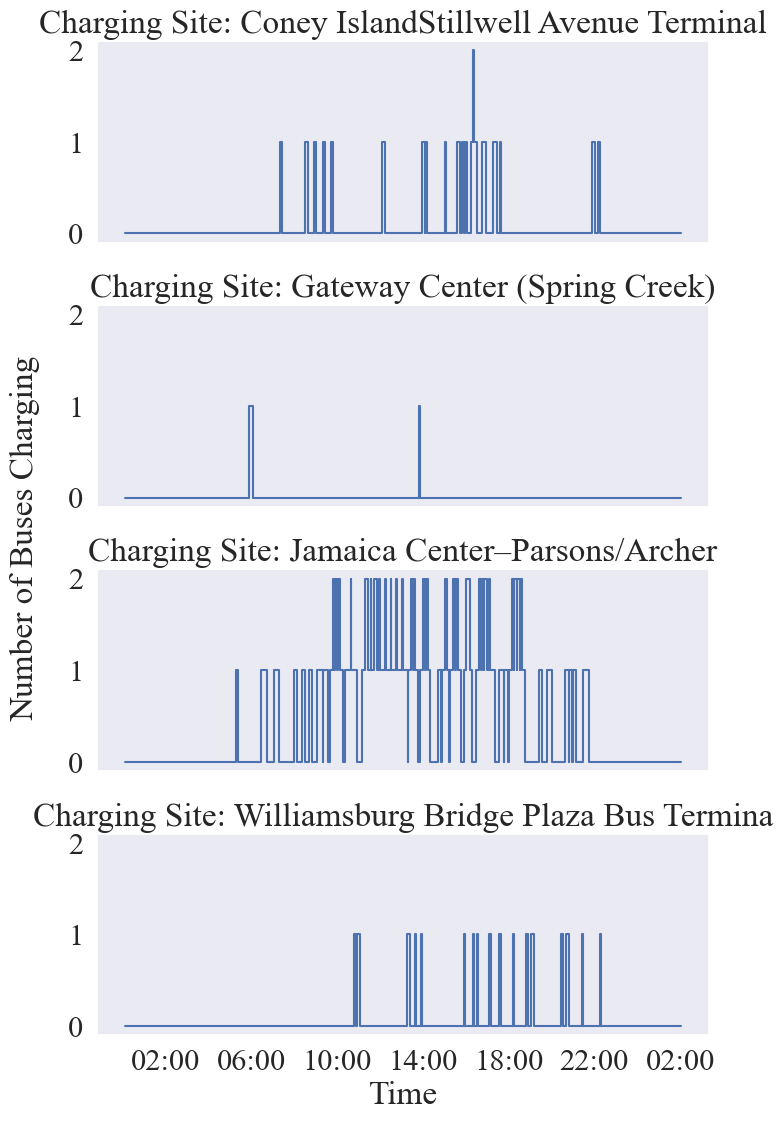

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


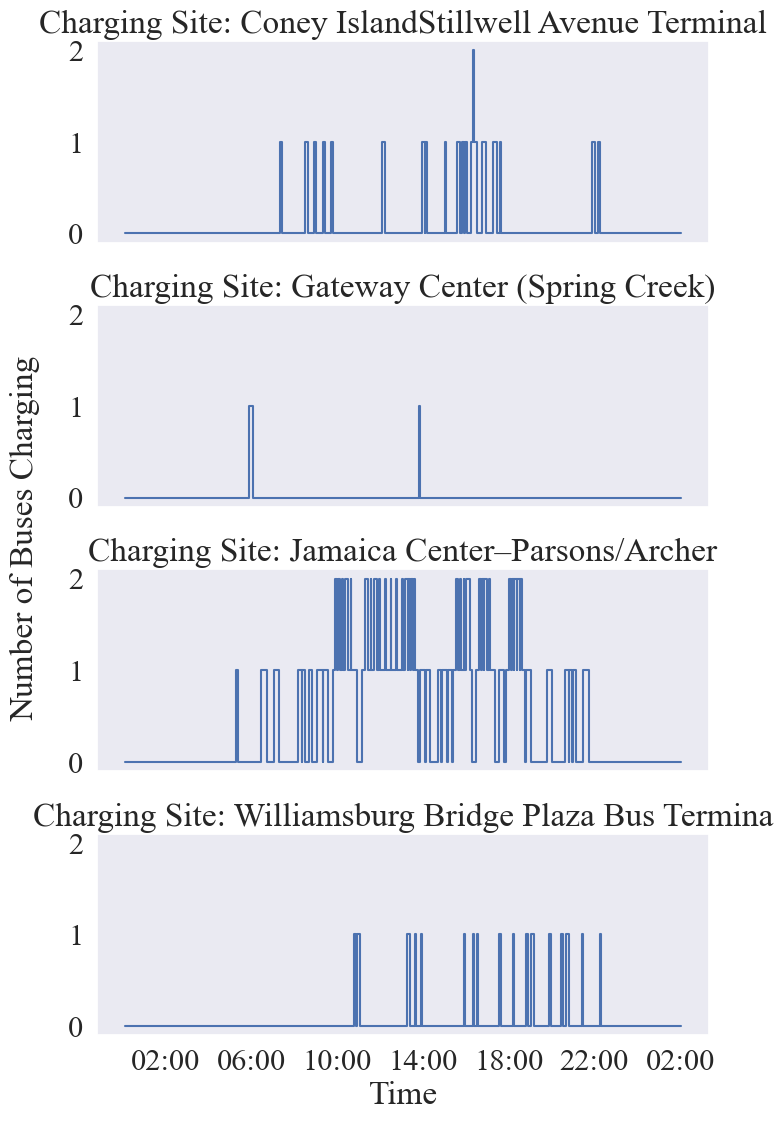

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


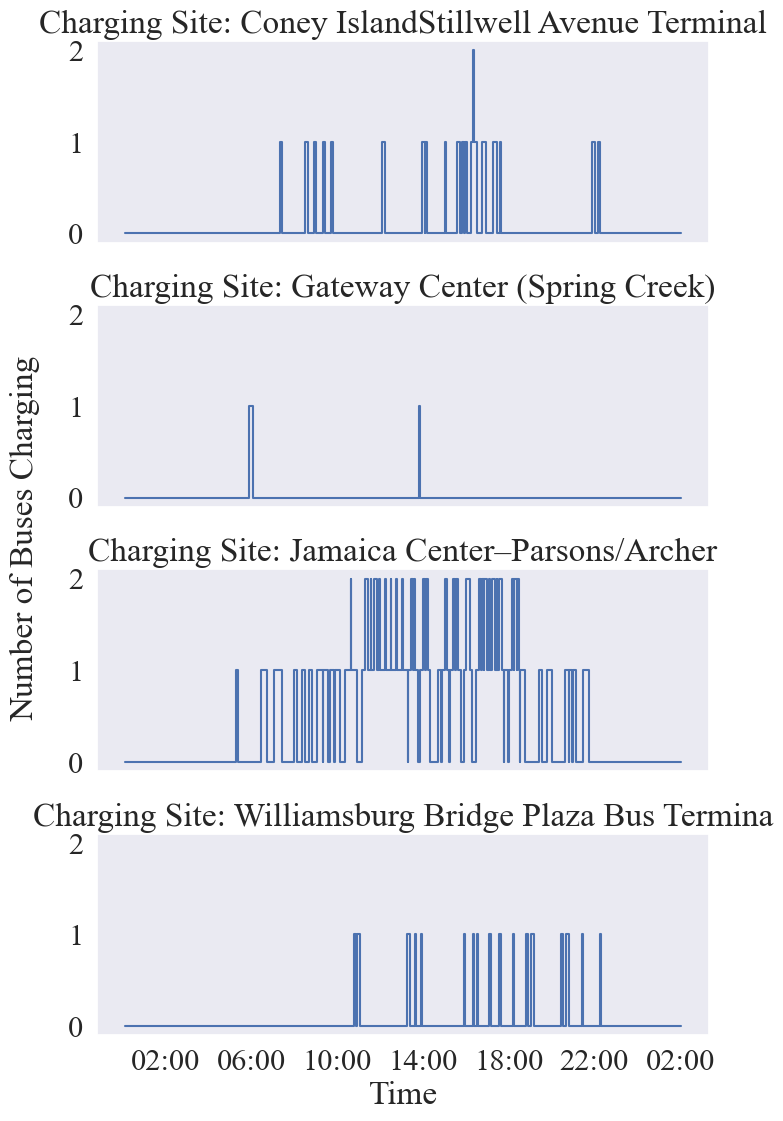

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


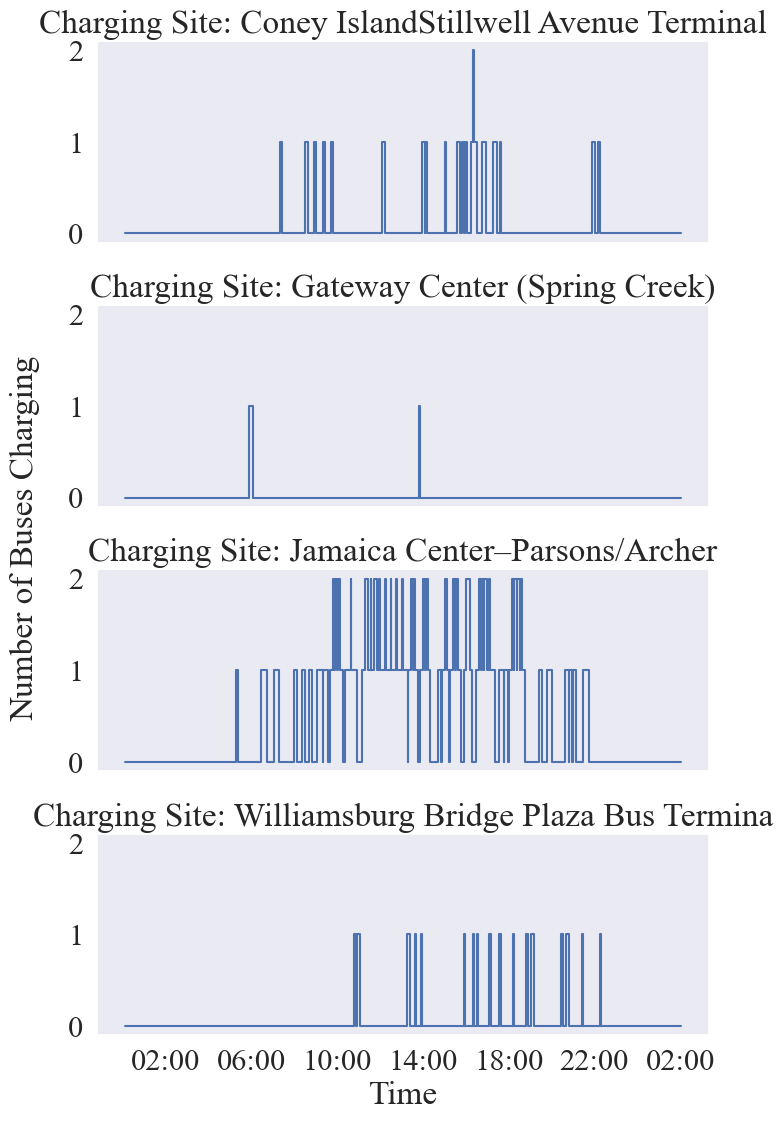

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


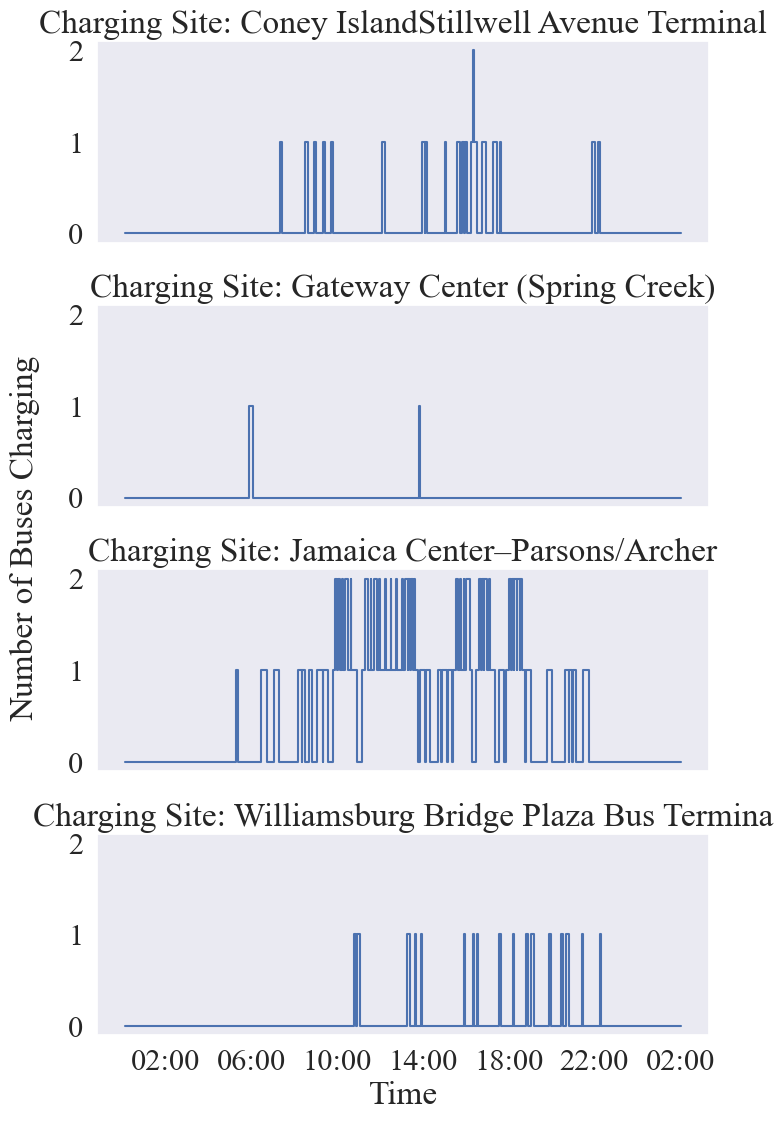

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


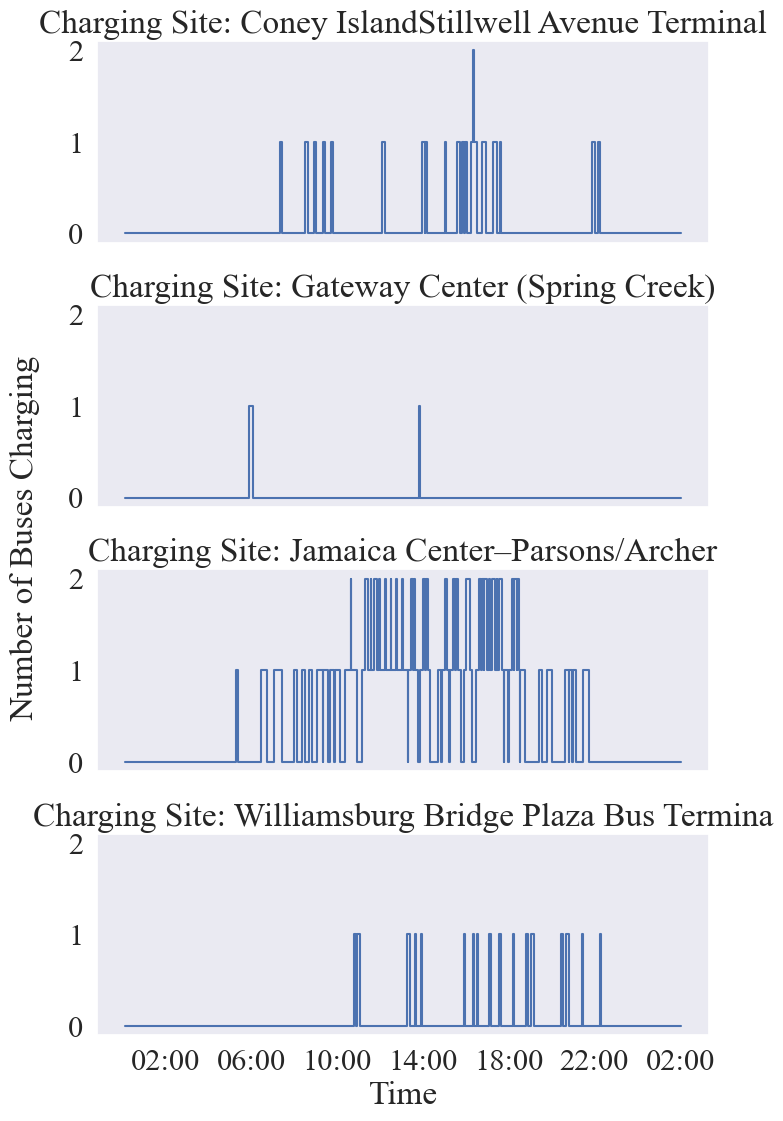

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


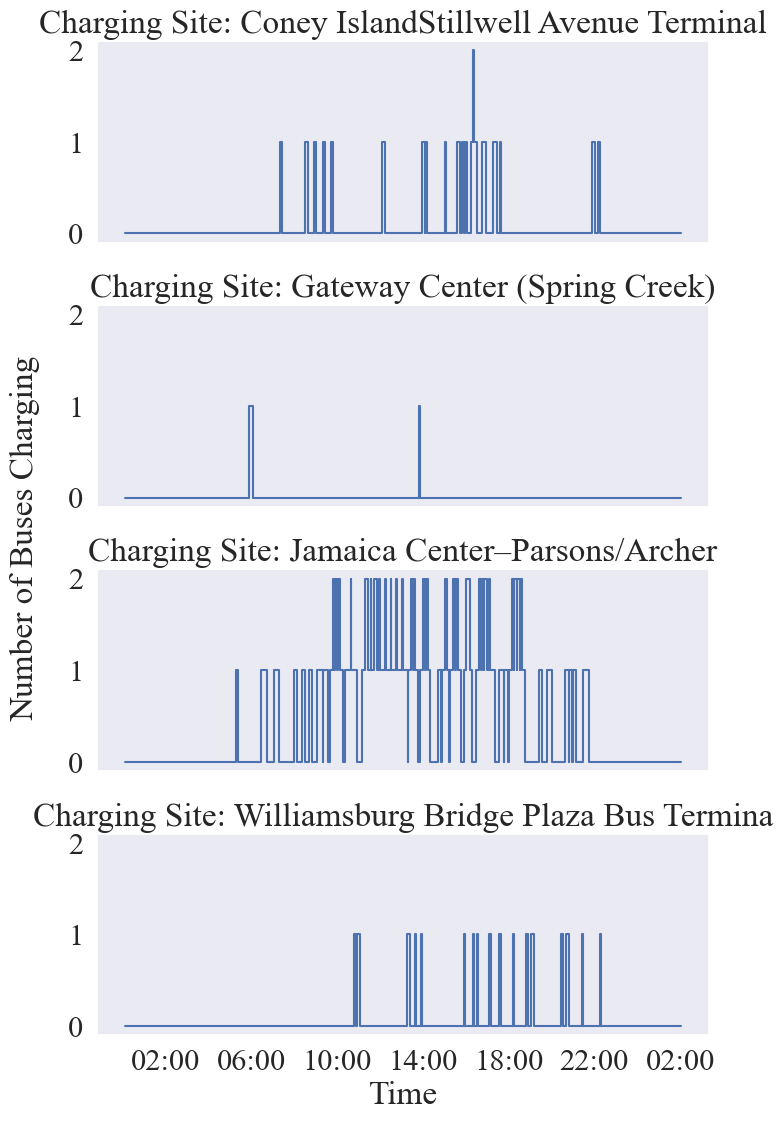

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


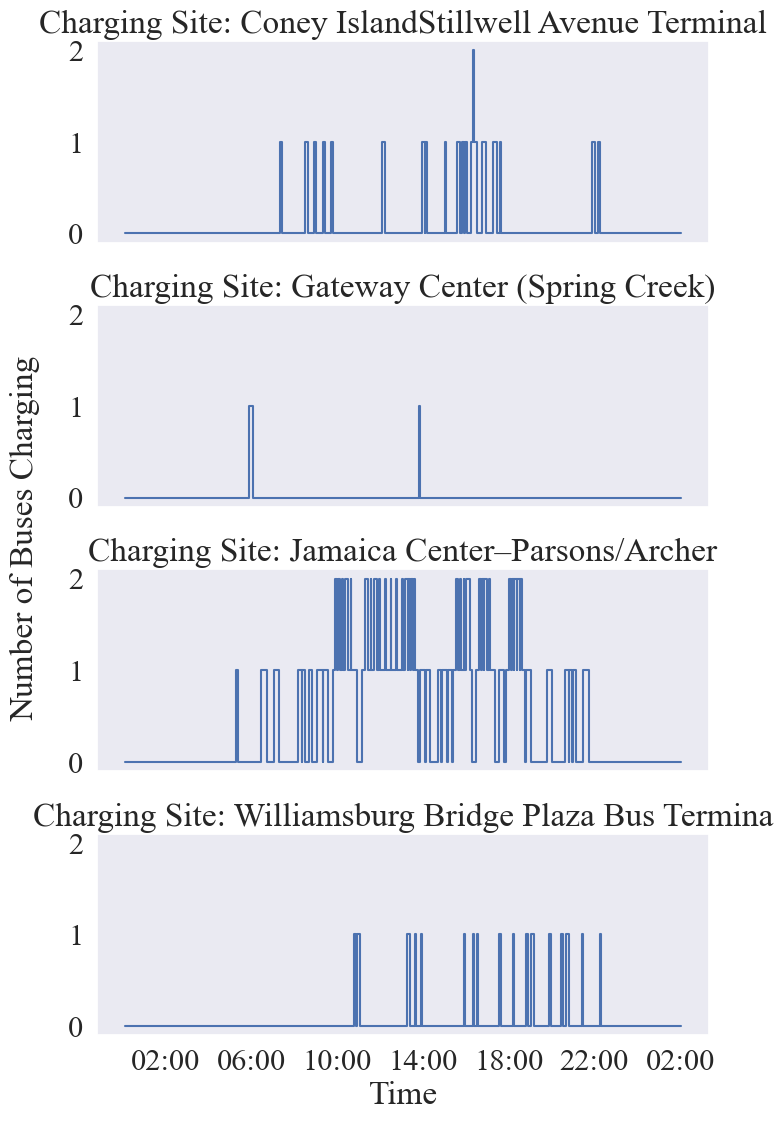

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


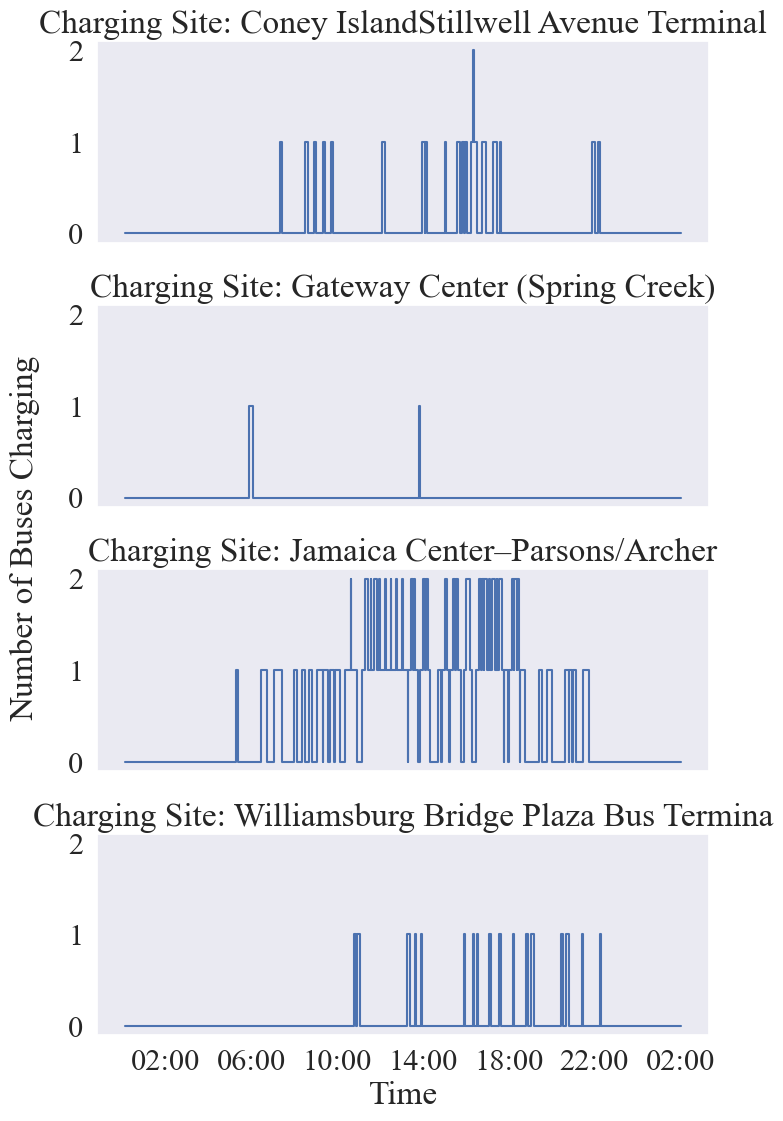

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


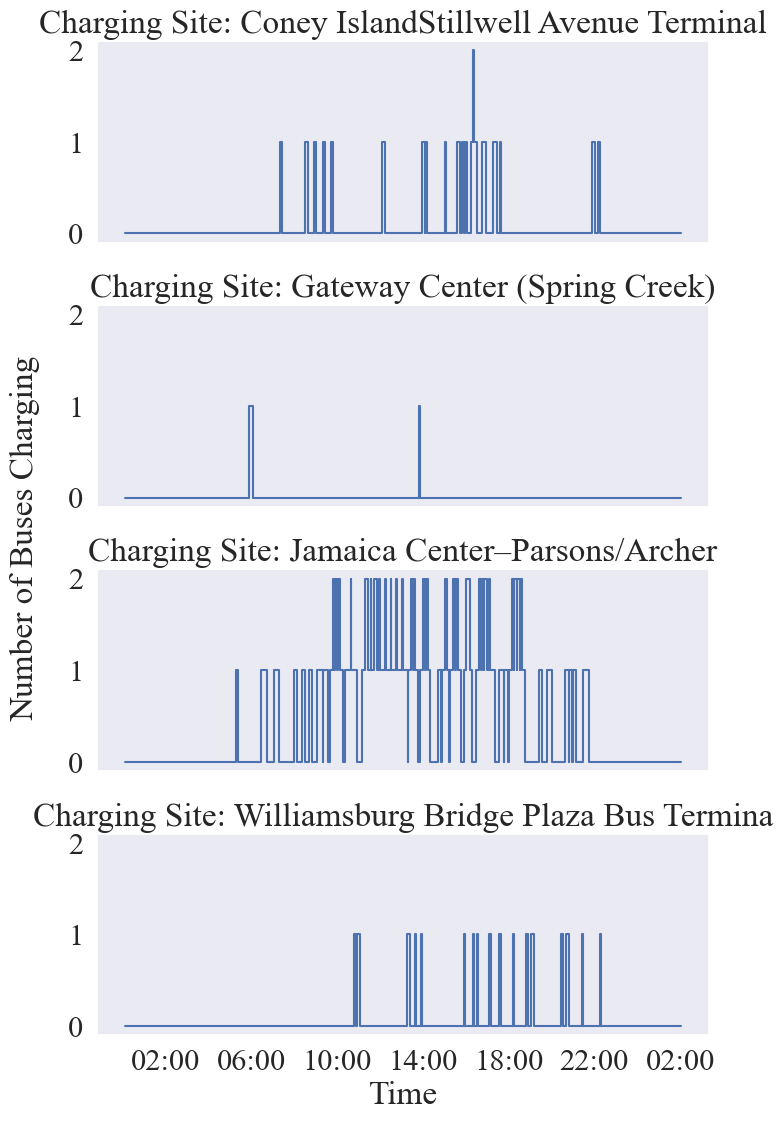

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


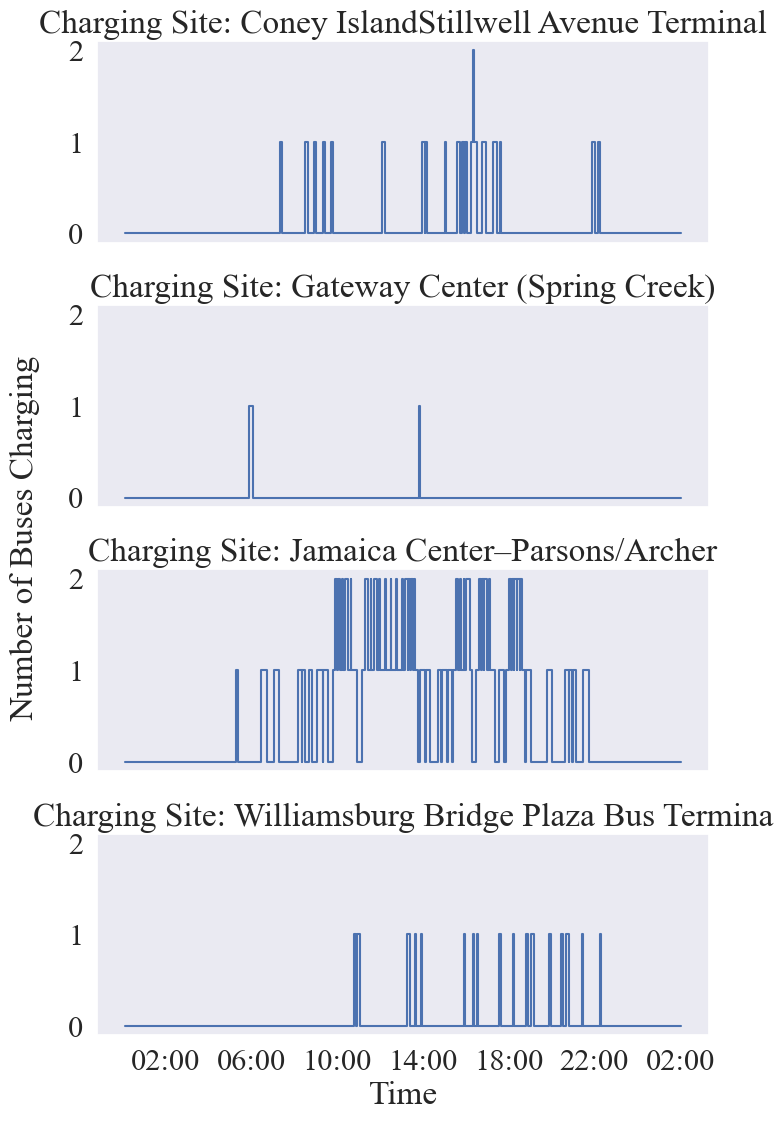

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


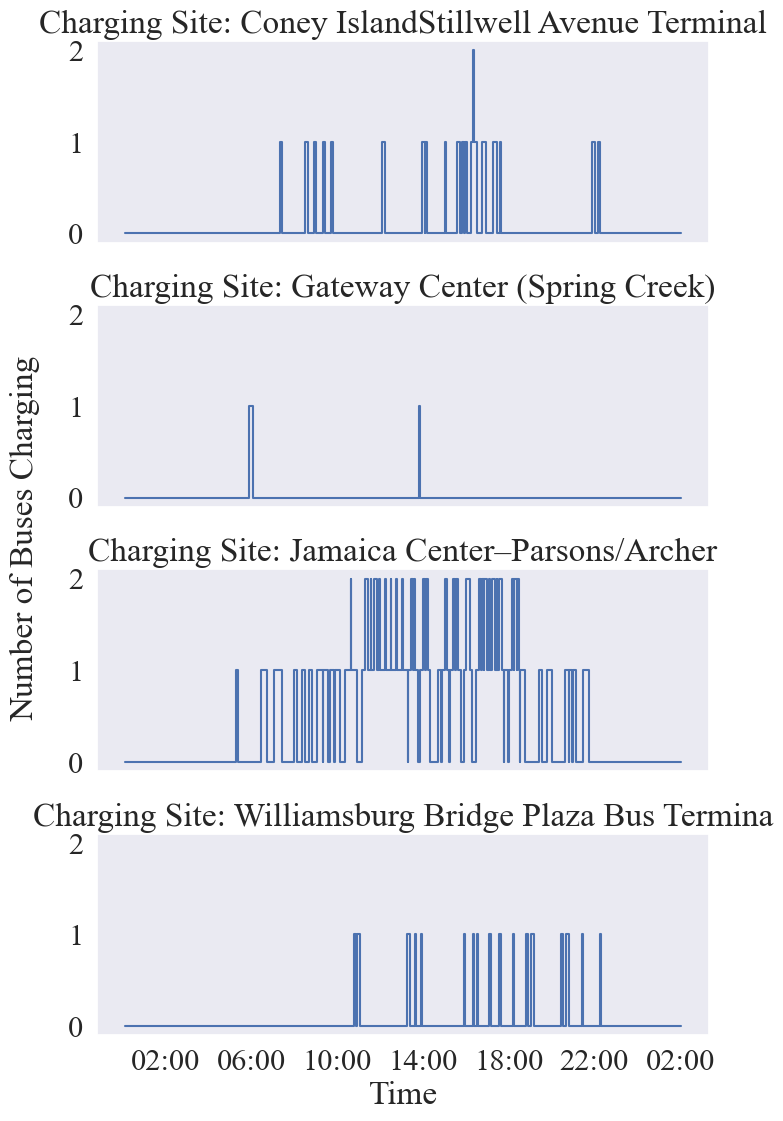

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


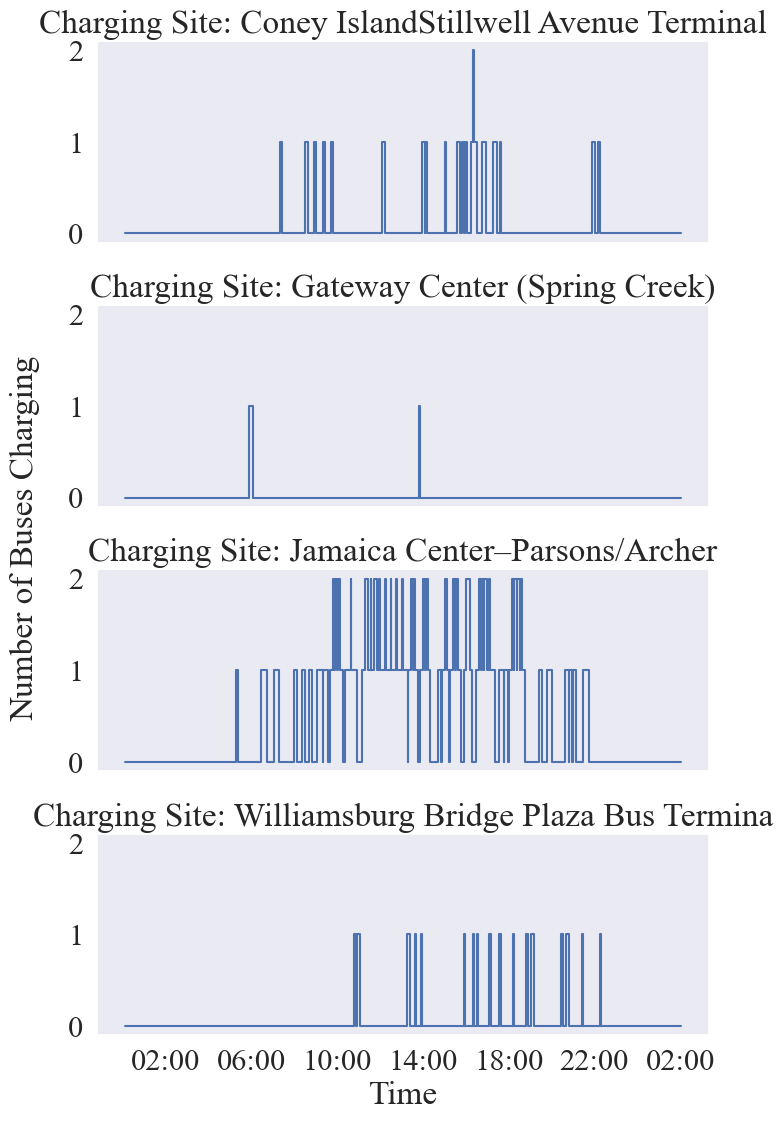

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

Solved
File saved


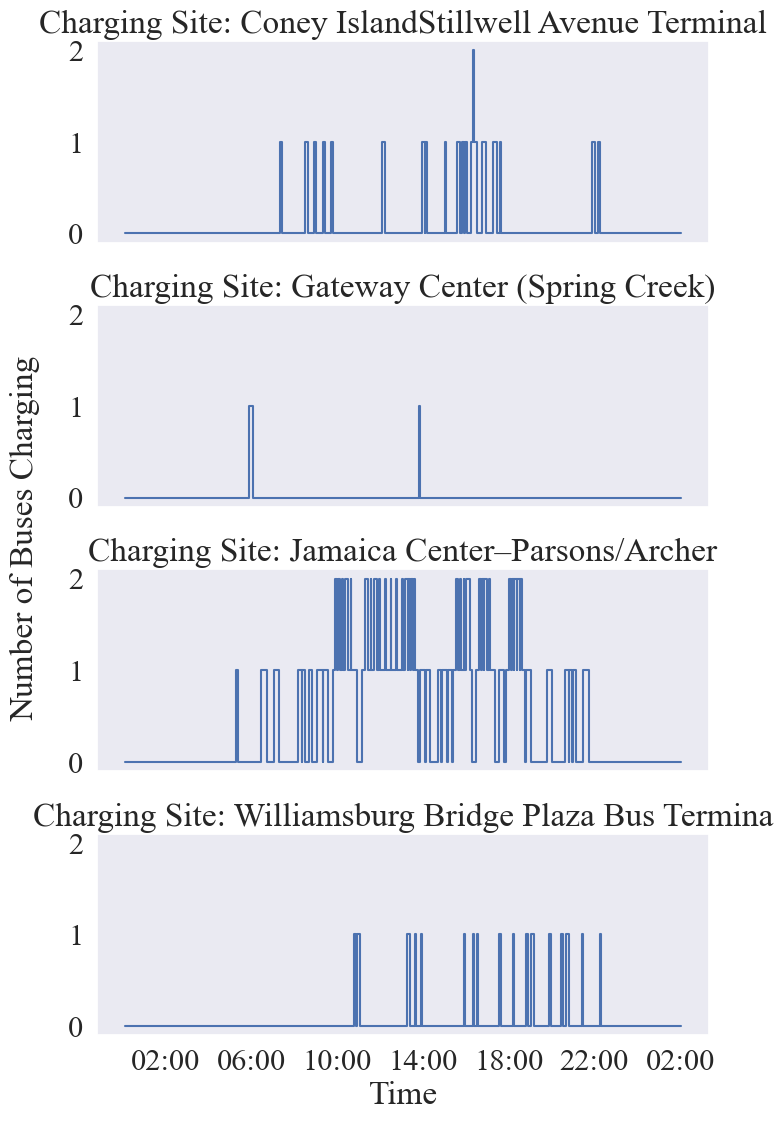

INFO:charger_location:Number of blocks that require charging: 192
INFO:charger_location:Number of trips in charging blocks: 2168


Instance created


INFO:charger_location:Number of infeasible blocks: 139
INFO:charger_location:Infeasible block IDs: ['36443450', '36443451', '36443453', '36443454', '36443456', '36443459', '36456999', '36457000', '36457001', '36457002', '36457004', '36457006', '36457007', '36457012', '36457013', '36457014', '36457015', '36457016', '36457017', '36457018', '36457020', '36457021', '36457023', '36457024', '36457025', '36457027', '36457028', '36457029', '36457030', '36457031', '36457032', '36457033', '36457034', '36457035', '36457037', '36457039', '36457041', '36457042', '36457043', '36457044', '36457045', '36457046', '36457047', '36457048', '36457049', '36457050', '36457051', '36457052', '36457054', '36457055', '36457056', '36457057', '36457058', '36457059', '36457060', '36457061', '36457062', '36457075', '36457125', '36457126', '36457127', '36457128', '36457130', '36457132', '36457133', '36457134', '36457135', '36457136', '36457137', '36457139', '36457140', '36457142', '36457143', '36457145', '36457149', 

KeyboardInterrupt: 

In [56]:
for battery_cap in battery_cap_list:
    for n_max in n_max_list:
        for s_cost in s_cost_list:
            for c_cost in c_cost_list:
                opt_model(n_max, s_cost, c_cost, battery_cap, gtfs=gtfs, beb_trips=beb_trips, loc_df=loc_df, depot_coords=depot_coords)